--------------------------

## MAJADAS_FORCING

He ido anotando qué hace cada celda, y dentro del código he añadido cosas, cambiado o comentado; además de modificar los path.

Primera celda: tiene los import, algunos paths, la configuración de las gráficas y alguna función corta.

In [32]:
import icoscp;
from icoscp.cpb.dobj import Dobj;
import sys
sys.path.append("~/.local/lib/python3.10/site-packages/")
from meteo import air,humidity
import meteo
# from meteo import * # lo he añadido yo a ver si funciona
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import atmos
from datetime import date, datetime, timedelta
import os
import time
# import epygram # no lo usa y no lo tengo
from pathlib import Path
import netCDF4 as nc
import datetime as dt
import matplotlib.dates as mdates
import xarray as xr
import calendar
import seaborn as sns

# Paths
# home = str(Path.home())
home = 'D:/Computacional/TFM'
figs_path = "D:/Computacional/TFM/figures_majadas/"

# Para establecer cómo serán las figuras creadas:
matplotlib.rcParams['lines.linewidth'] = 1 # esto se irá cambiando según interese
plt.rcParams['figure.dpi'] = 100 # no entiendo si quieren 500 o 100, he visto ambas
matplotlib.rcParams.update({'font.size': 12}) # estaba a 14 antes
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

def datespan(startDate, endDate, delta=timedelta(days=1)):
    currentDate = startDate
    while currentDate < endDate:
        yield currentDate
        currentDate += delta

def despike(pandas_column, sigma_delta):
   # This function substitutes spikes in data (replaced by nan)
   # The finding criteria for a spike is that contiguous values differ by
   # more than 3*sigma wrt the distribution of series of differences between consecutive values
   delta_z_abs=np.abs(stats.zscore(pandas_column.diff(1),nan_policy='omit'))
   delta_z_abs[0]=0 # Make first value zero instead of nan
   pandas_column_filtered=pandas_column.where(delta_z_abs<sigma_delta, np.nan)
   return pandas_column_filtered

def reduce_pres(pandas_column,station_height):
    #This function reduces pressure in Pa from surface to station height
    #It assumes a pressure gradient of 100 Pa each 9m
    pandas_column_reduced=pandas_column-100*station_height/9
    return pandas_column_reduced

######### Configuration of the forcing/validation exercise
station_name='Majadas_south' #Select between Norunda, Svartberget, Hyltemossa, Bilos(FR)
short_name='Majadas'
write_forcing_wup='no'   #Set to yes for writing forcing in files
write_forcing_run='no'   #Set to yes for writing forcing in files
limcr_inf=0.5        #lower closure rate limit for include SEB data in validation
limcr_sup=1.5    #upper limit for include SEB data in validation
#Common parameters for Params_config.txt in the three sites
delta_t=1800 # timestep in 
Use_Scan='yes' #Evaluate energy storage in the canopy
filter_HLE='yes'  #Decide if filter some dates with bad quality data from visual inspection (by Meto)
#Define dates to clean by station_name:
datess=[]    
#define periods for warm-up (spin-up) and simulation
# 1 month simulations:
wup_start='2018-9-1 00:00:00'
wup_end='2019-1-1 00:00:00'
run_start='2019-1-1 00:00:00'
run_end='2020-1-1 00:00:00'

if station_name=='Majadas_south':
 
 obj_flux='https://meta.icos-cp.eu/objects/dDlpnhS3XKyZjB22MUzP_nAm'

 #TS levels from 1...7 go from 0 to -1m
 delta_t=1800
 lon=-5.774722
 lat= 39.940556
 alt=258
 height_T=2
 height_V=10
 Tree_height=9.5
 height_flux=15.6
 LAI=2.75
 grass_height=0.2  #First order approx is continuous value through the year

In [33]:
# # lists to control line styles and colors:
# linstyles=['dashed','solid','dashed','solid']
# colors=['b','b','g','g']

Ahora se nombran los experimentos, por ahora están el difusivo de referencia y el difusivo con DSL, pero habrá que añadir el MEB (Multi Energy Balance) para referencia y DSL.\
Entonces resumiendo: nos olvidamos de activar MEB en el PATCH1, y tendremos tres experimentos:\
DIF_REF\
DIF_DSL\
MEB_DSL (que significa que DSL se activa también en el PATCH2, es decir, el PATCH que usa MEB).

In [34]:
HOMEFOLDER='D:/Computacional/TFM/Majadas_south_run_BNR/' ##########    harlike/'   or    BNR/'

#Define experiment name
# exps=['DIF_REF', 'DIF_DSL'] 
exps=['DIF_REF', 'DIF_DSL', 'MEB_DSL'] # 'MEB_REF' 'DIF_DSL'

MAJADASSOUTH_MOD TIENE que ser el equivalente a MPOLE_MOD. Aquí es donde en teoría se guardan los datos de los experimentos.

In [35]:
MAJADASSOUTH_MOD=pd.DataFrame()
datetime_start = dt.datetime(2019,1,1) # PONÍA 2017, pero queremos 2017 como en meteopole o 2019 como en los forzamientos???
for exp in exps:
    #Load variables in diagnostic surfex file:
    file=HOMEFOLDER+exp+'/run/ISBA_DIAGNOSTICS.OUT.nc'
    ds = xr.open_dataset(file,decode_times=False)
    # ['H_P1','LE_P1','T2M_ISBA','W10M_ISBA','Q2M_ISBA','HU2M_ISBA','CD_P1','CH_P1','CQ_P1','RI_P1','FMU_P1','FMV_P1','TG1_ISBA','SWD_P1', 'SWU_P1','LWD_P1', 'LWU_P1','TSWI1_P1','TSWI2_P1','TSWI3_P1','TSWI4_P1','LEV_P1','LEG_P1']:
    for field in ['H_ISBA','LE_ISBA','T2M_ISBA','W10M_ISBA','Q2M_ISBA','HU2M_ISBA','CD_ISBA','CH_ISBA','CQ_ISBA','RI_ISBA','FMU_ISBA','FMV_ISBA','TG1_ISBA','SWD_ISBA', 'SWU_ISBA','LWD_ISBA', 'LWU_ISBA','TSWI1_ISBA','TSWI2_ISBA','TSWI3_ISBA','TSWI4_ISBA','LEV_ISBA','LEG_ISBA']:
     print(field,exp)
     try:    
      MAJADASSOUTH_MOD[field.split('_')[0]+'_'+exp] = ds[field].data[:, ...].ravel()
     except:
      print('failed')
     pass

    ########### esto siguiente no estaba, lo he añadido yo:
    # pero parece que no añade parametros al DataFrame
    #Load variables in prognostic surfex file:    
    file=HOMEFOLDER+exp+'/run/ISBA_PROGNOSTIC.OUT.nc'
    ds = xr.open_dataset(file,decode_times=False)
    for field in ['LMOISBA','BETAHFISBA','Z0MISBA']:
     print(field,exp)
     try:    
      MAJADASSOUTH_MOD[field.split('_')[0]+'_'+exp] = ds[field].data[:, ...].ravel()
     except:
      print('failed')
     pass
    #Convert LMOP5 to z/L parameter
    for field in ['LMOISBA']:
     print(field,exp)
     try:
      MAJADASSOUTH_MOD['Z'+field+'_'+exp]=height_flux/MAJADASSOUTH_MOD.loc[:,[field+'_'+exp]]
     except:
      print('failed')
     pass

    #Read TG1 or TC and store it as surface temperature depending if FR or MEB
    for field in ['TCISBA']:
     print(field,exp)
     if 'FR' in exp:
      field='TG1P5'
     try:
      MAJADASSOUTH_MOD.loc[:,['TSEFF_'+exp]] = ds[field].data[:, ...].ravel()
     except:
      print('failed')
     pass
     pass
    
MAJADASSOUTH_MOD['minutes']=ds['time'].data[:, ...].ravel()       
MAJADASSOUTH_MOD['DATETIME'] = datetime_start+pd.TimedeltaIndex(MAJADASSOUTH_MOD.minutes, unit='m')
MAJADASSOUTH_MOD.set_index('DATETIME',inplace=True)
MAJADASSOUTH_MOD.head(2)

H_ISBA DIF_REF
LE_ISBA DIF_REF
T2M_ISBA DIF_REF
W10M_ISBA DIF_REF
Q2M_ISBA DIF_REF
HU2M_ISBA DIF_REF
CD_ISBA DIF_REF
CH_ISBA DIF_REF
CQ_ISBA DIF_REF
failed
RI_ISBA DIF_REF
FMU_ISBA DIF_REF
FMV_ISBA DIF_REF
TG1_ISBA DIF_REF
SWD_ISBA DIF_REF
failed
SWU_ISBA DIF_REF
failed
LWD_ISBA DIF_REF
failed
LWU_ISBA DIF_REF
failed
TSWI1_ISBA DIF_REF
TSWI2_ISBA DIF_REF
TSWI3_ISBA DIF_REF
TSWI4_ISBA DIF_REF
LEV_ISBA DIF_REF
LEG_ISBA DIF_REF
LMOISBA DIF_REF
failed
BETAHFISBA DIF_REF
failed
Z0MISBA DIF_REF
failed
LMOISBA DIF_REF
failed
TCISBA DIF_REF
failed
H_ISBA DIF_DSL
LE_ISBA DIF_DSL
T2M_ISBA DIF_DSL
W10M_ISBA DIF_DSL
Q2M_ISBA DIF_DSL
HU2M_ISBA DIF_DSL
CD_ISBA DIF_DSL
CH_ISBA DIF_DSL
CQ_ISBA DIF_DSL
failed
RI_ISBA DIF_DSL
FMU_ISBA DIF_DSL
FMV_ISBA DIF_DSL
TG1_ISBA DIF_DSL
SWD_ISBA DIF_DSL
failed
SWU_ISBA DIF_DSL
failed
LWD_ISBA DIF_DSL
failed
LWU_ISBA DIF_DSL
failed
TSWI1_ISBA DIF_DSL
TSWI2_ISBA DIF_DSL
TSWI3_ISBA DIF_DSL
TSWI4_ISBA DIF_DSL
LEV_ISBA DIF_DSL
LEG_ISBA DIF_DSL
LMOISBA DIF_DSL
failed
BE

,H_DIF_REF,LE_DIF_REF,T2M_DIF_REF,W10M_DIF_REF,Q2M_DIF_REF,HU2M_DIF_REF,CD_DIF_REF,CH_DIF_REF,RI_DIF_REF,FMU_DIF_REF,...,FMU_MEB_DSL,FMV_MEB_DSL,TG1_MEB_DSL,TSWI1_MEB_DSL,TSWI2_MEB_DSL,TSWI3_MEB_DSL,TSWI4_MEB_DSL,LEV_MEB_DSL,LEG_MEB_DSL,minutes
DATETIME,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:30:00,0.617112,0.238994,274.067924,2.008167,0.004083,0.999789,0.224188,0.224186,-0.002164,0.0,...,0.0,-1.226626,274.772133,0.971802,0.961028,0.959834,0.964516,-0.93460,0.596319,30.0
2019-01-01 01:00:00,3.258604,1.873368,273.929837,1.658167,0.004043,0.999794,0.224188,0.224186,-0.003881,0.0,...,0.0,-0.838215,274.617797,0.971816,0.961036,0.959823,0.964462,-0.27447,0.566378,60.0


In [36]:
MAJADASSOUTH_MOD

,H_DIF_REF,LE_DIF_REF,T2M_DIF_REF,W10M_DIF_REF,Q2M_DIF_REF,HU2M_DIF_REF,CD_DIF_REF,CH_DIF_REF,RI_DIF_REF,FMU_DIF_REF,...,FMU_MEB_DSL,FMV_MEB_DSL,TG1_MEB_DSL,TSWI1_MEB_DSL,TSWI2_MEB_DSL,TSWI3_MEB_DSL,TSWI4_MEB_DSL,LEV_MEB_DSL,LEG_MEB_DSL,minutes
DATETIME,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:30:00,0.617112,0.238994,274.067924,2.008167,0.004083,0.999789,0.224188,0.224186,-0.002164,0.0,...,0.0,-1.226626,274.772133,0.971802,0.961028,0.959834,0.964516,-0.934600,0.596319,30.0
2019-01-01 01:00:00,3.258604,1.873368,273.929837,1.658167,0.004043,0.999794,0.224188,0.224186,-0.003881,0.0,...,0.0,-0.838215,274.617797,0.971816,0.961036,0.959823,0.964462,-0.274470,0.566378,60.0
2019-01-01 01:30:00,13.199269,2.175434,273.392082,0.563667,0.003877,0.996878,0.224188,0.224187,-0.089118,0.0,...,0.0,-0.099596,274.177046,0.971802,0.961027,0.959804,0.964405,0.063930,0.652936,90.0
2019-01-01 02:00:00,22.273165,3.530024,272.760829,0.761333,0.003678,0.990252,0.224188,0.224187,-0.059951,0.0,...,0.0,-0.181092,273.647710,0.972030,0.960924,0.959775,0.964347,0.079589,0.754512,120.0
2019-01-01 02:30:00,19.056856,3.481370,272.412626,1.004500,0.003573,0.987008,0.224188,0.224186,-0.028594,0.0,...,0.0,-0.313068,273.300110,0.973934,0.960432,0.959660,0.964284,0.033570,0.732787,150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 22:00:00,1.435029,1.234976,276.088376,1.337833,0.004714,0.999835,0.224188,0.224187,-0.006808,0.0,...,0.0,-0.543181,276.822402,1.026114,1.015286,1.014664,1.020292,-0.179972,0.822986,525480.0
2019-12-31 22:30:00,4.438458,2.059556,275.804327,0.928500,0.004618,0.999526,0.224188,0.224187,-0.019476,0.0,...,0.0,-0.263707,276.544427,1.026009,1.015178,1.014545,1.020150,-0.120172,0.807977,525510.0
2019-12-31 23:00:00,-1.398188,-1.105214,275.726456,0.927833,0.004593,0.999833,0.224188,0.224187,-0.012717,0.0,...,0.0,-0.262826,276.406824,1.025906,1.015070,1.014427,1.020011,-1.319647,0.742183,525540.0


In [37]:
#Load Object containing radiation
#Load Object containing fluxes, eddy covariances etc

file_path = "D:/Computacional/TFM/FLX_ES-LM2_FLUXNET2015_FULLSET_HH_2014-2020_beta-3.csv"

Station_forcing=pd.read_csv(file_path)
Station_forcing['TIMESTAMP'] = pd.to_datetime(Station_forcing['TIMESTAMP_START'], format='%Y%m%d%H%M')
Station_forcing.set_index('TIMESTAMP', inplace=True)

#For Norunda, Svartberget, Hyltemossa (offline 1d or offline 1d to compare to 3d)
#We get station data from the levels stated at previos cell
Station_forcing['Forc_LW']=Station_forcing['LW_IN_F']
#New column with SNOW pcp and populate with zero values
Station_forcing['Forc_SNOW']=Station_forcing['P_F']*0
#New column with Forc_CO2 and populate it with constant value.
Station_forcing['Forc_CO2']=0.00062
#Substitute negative SW values for zero values
Station_forcing['Forc_DIR_SW']=np.where(Station_forcing['SW_IN_F'].values<0, 0, Station_forcing['SW_IN_F'])
#New column for scattered/diffuse SW and populate with zero values
Station_forcing['Forc_SCA_SW']=Station_forcing['Forc_DIR_SW']*0
Station_forcing.Forc_SCA_SW.values[:]=0
#Convert Precipitation to precipitation rate
Station_forcing['Forc_RAIN']=Station_forcing['P_F']/delta_t
#Rename other varialbes to suitable forcing file names
Station_forcing.rename(columns={"TA_F":"Forc_TA","PA_F": "Forc_PS","WS_F":"Forc_WIND"},inplace=True)
Station_forcing.rename(columns={"LE_F_MDS":"LE","H_F_MDS": "H"},inplace=True)

#Drop duplicate variables
#Station_forcing=Station_forcing.drop(columns=['P','LW_IN','SW_IN'])
Station_forcing['Forc_PS']=Station_forcing['Forc_PS']*1000 #Convert to Pa
Station_forcing['Forc_DIR']=Station_forcing['Forc_WIND']*0
Station_forcing['Forc_TA']=Station_forcing['Forc_TA']+273.15 #Convert to Pa
Station_forcing['ESAT']=humidity.esat(Station_forcing['Forc_TA']) #Saturated vapour pressure in Pa
Station_forcing['E']=Station_forcing['ESAT']-Station_forcing['VPD_F']*100

def rh2ah(RH,p,T):
   '''conversion relative humidity to absolute humidity (kg Water per m^3 Air)'''
   mixr=humidity.rh2mixr(RH, p,T)
   sh=humidity.mixr2sh(mixr)
   return  sh*air.rhov(T,p)

Station_forcing['Forc_QA']=rh2ah(Station_forcing['E']/Station_forcing['ESAT'],Station_forcing['Forc_PS'],Station_forcing['Forc_TA'])

In [38]:
prueba = pd.read_csv(file_path)

In [8]:
prueba.columns

Index(['TIMESTAMP_START', 'TIMESTAMP_END', 'TA_F_MDS', 'TA_F_MDS_QC', 'TA_ERA',
       'TA_F', 'TA_F_QC', 'SW_IN_POT', 'SW_IN_F_MDS', 'SW_IN_F_MDS_QC',
       ...
       'GPP_DT_CUT_SE', 'GPP_DT_CUT_05', 'GPP_DT_CUT_16', 'GPP_DT_CUT_25',
       'GPP_DT_CUT_50', 'GPP_DT_CUT_75', 'GPP_DT_CUT_84', 'GPP_DT_CUT_95',
       'RECO_SR', 'RECO_SR_N'],
      dtype='object', length=243)

Ahora se hacen dos cosas, por una parte se crean y guardan imágenes de las series temporales de forzamientos, que vienen de 'forcing_run', se imprimen por pantalla las disitntas variables.\
Se imprimían antes la cantidad de nans, infs y zeros de cada serie, pero lo he comentado. Se puede ver también visualmente en las gráficas.\
Las imágenes se guardan en 'figures' con el nombre 'Majadas_Forc_[variable].png'\
Se definen:\
Station_forcing_wup=Station_forcing.loc[wup_start:wup_end]\
Station_forcing_run=Station_forcing.loc[run_start:run_end]

In [39]:
#Load forcings into the pandas dataframe. Plot timeseries just in case.
#I skip the first value which corresponds to 00:00
forcing_vars=['Forc_CO2','Forc_DIR','Forc_PS','Forc_RAIN','Forc_SNOW','Forc_WIND','Forc_DIR_SW','Forc_LW','Forc_QA','Forc_SCA_SW','Forc_TA']
forcing_names=['Near surface CO2 concentration', 'Wind direction', 'Atmospheric pression', 'Rain', 'Snow precipitation', 'Wind speed',
               'Direct short-wave radiation', 'Long-wave radiation', 'Atmospheric humidity', 'Diffuse short-wave radiation', 'Atmospheric temperature']
forcing_units=['kg/m3', 'W/m2', 'Pa', 'kg/m2/s', 'kg/m2/s', 'm/s', 'W/m2', 'W/m2', 'kg/kg', 'W/m2', 'K']
# FORPATH='D:/Computacional/TFM/Meteopole_BNR/forcing_run/'


#Select wup data and save it, along with a working Params_config.txt
Station_forcing_wup=Station_forcing.loc[wup_start:wup_end]
Station_forcing_wup.shape
Station_forcing_wup.columns
os.makedirs(home+'/'+station_name+'_run/'+'forcing_wup',exist_ok=True)
os.chdir(home+'/'+station_name+'_run/'+'forcing_wup')

for item in forcing_vars:
 # print(item, 'with '+ str(Station_forcing_wup[item].isna().sum())+ 'nans')
 if write_forcing_wup=='yes':
   np.savetxt(item+'.txt', Station_forcing_wup[item].fillna(method='bfill').fillna(method='ffill').values, fmt='%.6f')

lines = [1, Station_forcing_wup[item].values.shape[0], delta_t,Station_forcing_wup.index[1].year,
         Station_forcing_wup.index[1].month,Station_forcing_wup.index[1].day,Station_forcing_wup.index[1].hour,
         lon,lat,alt, height_T,height_V]
if write_forcing_wup=='yes':
 with open(home+'/'+station_name+'_run/'+'forcing_wup/Params_config.txt', 'w') as f:
    for line in lines:
        f.write(str(line))
        f.write('\n')
 f.close()

#Select run data and save it, along with a working Params_config.txt
Station_forcing_run=Station_forcing.loc[run_start:run_end]
Station_forcing_run.shape
Station_forcing_run.columns
os.makedirs(home+'/'+station_name+'_run/'+'forcing_run',exist_ok=True)
os.chdir(home+'/'+station_name+'_run/'+'forcing_run')

i = 0
print('These are the forcing variables:')
for item in forcing_vars:
 print(item)
 # print(item, 'with '+ str(Station_forcing_run[item].isna().sum())+ 'nans')
 if write_forcing_run=='yes':
  np.savetxt(item+'.txt', Station_forcing_run[item].fillna(method='bfill').fillna(method='ffill').values, fmt='%.6f')
 fig, axs = plt.subplots(figsize=(16, 3)) # inicialmente estaba a (17,5)
 Station_forcing_run[item].plot(ax=axs,label=item+'no_filter', color='green')
 axs.set_ylabel(str(item)+' ('+str(forcing_units[i])+')')
 axs.set_xlabel('')
 plt.title(forcing_names[i]+' - Majadas 2019')
 fig.savefig(figs_path+short_name+'_'+item+'.png',facecolor='white')
 plt.close()
 i+=1

#Generate Params_config text file:
lines = [1, Station_forcing_run[item].values.shape[0], delta_t,Station_forcing_run.index[1].year,
         Station_forcing_run.index[1].month,Station_forcing_run.index[1].day,Station_forcing_run.index[1].hour,
         lon,lat,alt, height_T,height_V]
if write_forcing_run=='yes':
 with open(home+'/'+station_name+'_run/'+'forcing_run/Params_config.txt', 'w') as f:
     for line in lines:
         f.write(str(line))
         f.write('\n')
 f.close()

Station_forcing_run['Forc_SW']=Station_forcing_run.Forc_DIR_SW+Station_forcing_run.Forc_SCA_SW
print('Forc_SW')

These are the forcing variables:
Forc_CO2
Forc_DIR
Forc_PS
Forc_RAIN
Forc_SNOW
Forc_WIND
Forc_DIR_SW
Forc_LW
Forc_QA
Forc_SCA_SW
Forc_TA
Forc_SW


C:\Users\begon\AppData\Local\Temp/ipykernel_14500/327344226.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Station_forcing_run['Forc_SW']=Station_forcing_run.Forc_DIR_SW+Station_forcing_run.Forc_SCA_SW


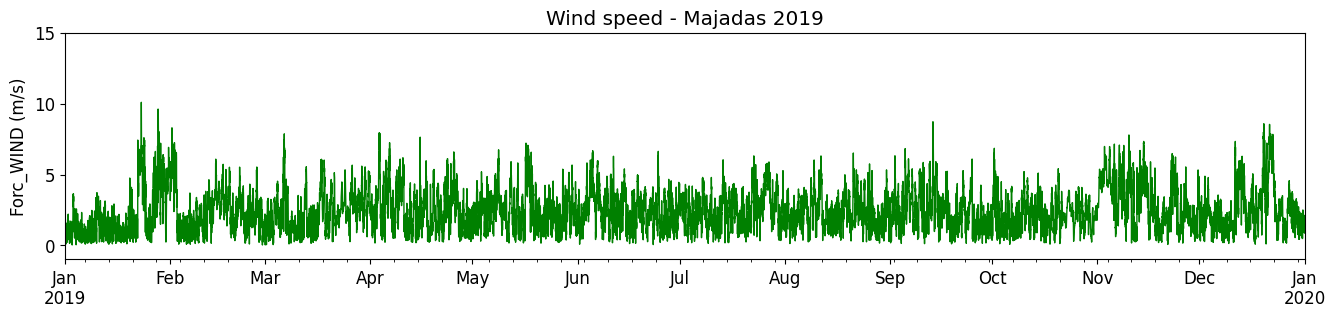

In [52]:
fig, axs = plt.subplots(figsize=(16, 3))
# gg = Station_forcing_run['Forc_QA']*1000
Station_forcing_run['Forc_WIND'].plot(ax=axs,label='Forc_WIND'+'no_filter', color='green')
axs.set_ylabel('Forc_WIND (m/s)')
axs.set_xlabel('')
axs.set_ylim([-1, 15])
plt.title('Wind speed - Majadas 2019')
fig.savefig(figs_path+'prueba'+'.png',facecolor='white')
plt.show()

Station_forcing_run no tiene equivalente, son las observaciones de forzamientos.

MAJADASSOUTH_MOD es equivalente a MPOLE_MOD

MAJA es equivalente a MPOLE, (recordemos que MPOLE = pd.concat([MPOLE_MOD,OBSERVATIONS,OBSERVATIONS1],axis=1))

La siguiente celda añade algunas variables a Station_forcing_run haciendo uso de otras ya existentes. Las variables que añade son para evaluar el 'canopy storage'.

No entiendo por qué hace esto con Station_forcing_run en vez de con MAJA AHHHHH.

In [53]:
#Evaluate canopy storage
Station_forcing_run.Tslope = pd.Series(np.diff(Station_forcing_run.Forc_TA), Station_forcing_run.index[:-1], name='slope')/delta_t
Station_forcing_run.Qslope = pd.Series(np.diff(Station_forcing_run.Forc_QA), Station_forcing_run.index[:-1], name='slope')/delta_t

cp=1004 # J Kg^-1 K-¹
Lv=2.5E6 # J/Kg
cveg=2650 # Kg^-1 K-¹
rho_veg=1.67 # kg m^-3

Station_forcing_run['rhoa']=meteo.rhov(Station_forcing_run.Forc_TA,Station_forcing_run.Forc_PS)  # 2m is the closer to canopy temperature, but...
Station_forcing_run['S_T']=cp*Station_forcing_run['rhoa']*grass_height*Station_forcing_run.Tslope
Station_forcing_run['S_veg']=cveg*rho_veg*grass_height*Station_forcing_run.Tslope
Station_forcing_run['S_q']=Lv*Station_forcing_run['rhoa']*grass_height*Station_forcing_run.Qslope

#Filter Scan for outliers if not nullified
nullify_Scan=1
if Use_Scan=='no':
 nullify_Scan=0
if nullify_Scan==1:
 #Cleaning of datasets for spikes which can degradate the closure scheme
 fields_to_smooth=['S_q','S_veg','S_T']
 for field in fields_to_smooth:
  #First despike data when the jump exceeds 3 times the sigma of the jumps distribution.
  Station_forcing_run[field]=despike(Station_forcing_run[field],3)
  #Then remove data where it exceeds 3 times de sigma of the distribution
  Station_forcing_run[field]=Station_forcing_run[field].where(np.abs(stats.mstats.zscore(Station_forcing_run[field],nan_policy='omit'))< 3, np.nan)
  #And fill nans with contiguous data
  Station_forcing_run[field]=Station_forcing_run[field].fillna(method='bfill').fillna(method='ffill')
#Final Scan value is the sum of the 3 components.
Station_forcing_run['S_can']=(Station_forcing_run['S_T']+Station_forcing_run['S_q']+Station_forcing_run['S_veg'])*nullify_Scan

C:\Users\begon\AppData\Local\Temp/ipykernel_14500/3601891317.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  Station_forcing_run.Tslope = pd.Series(np.diff(Station_forcing_run.Forc_TA), Station_forcing_run.index[:-1], name='slope')/delta_t
C:\Users\begon\AppData\Local\Temp/ipykernel_14500/3601891317.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  Station_forcing_run.Qslope = pd.Series(np.diff(Station_forcing_run.Forc_QA), Station_forcing_run.index[:-1], name='slope')/delta_t
C:\Users\begon\AppData\Local\Temp/ipykernel_14500/3601891317.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [54]:
#Cleaning of datasets for spikes which can degradate the closure scheme
fields_to_smooth=['H','LE'] #,'Cd','Ch','Cq','betaHF'
for field in fields_to_smooth:
 #First despike data when the jump exceeds 3 times the sigma of the jumps distribution.
 Station_forcing_run[field]=despike(Station_forcing_run[field],3)
 #Then remove data where it exceeds 3 times de sigma of the distribution
 Station_forcing_run[field]=Station_forcing_run[field].where(np.abs(stats.mstats.zscore(Station_forcing_run[field],nan_policy='omit'))< 3, np.nan)
 #And fill nans with contiguous data
 Station_forcing_run[field]=Station_forcing_run[field].fillna(method='bfill').fillna(method='ffill')

C:\Users\begon\AppData\Local\Temp/ipykernel_14500/1823665178.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Station_forcing_run[field]=despike(Station_forcing_run[field],3)
C:\Users\begon\AppData\Local\Temp/ipykernel_14500/1823665178.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Station_forcing_run[field]=Station_forcing_run[field].where(np.abs(stats.mstats.zscore(Station_forcing_run[field],nan_policy='omit'))< 3, np.nan)
C:\Users\begon\AppData\Local\Temp/ipykernel_14500/1823665178.py:9: SettingW

In [55]:
Station_forcing_run.head(2)

,TIMESTAMP_START,TIMESTAMP_END,TA_F_MDS,TA_F_MDS_QC,TA_ERA,Forc_TA,TA_F_QC,SW_IN_POT,SW_IN_F_MDS,SW_IN_F_MDS_QC,...,Forc_DIR,ESAT,E,Forc_QA,Forc_SW,rhoa,S_T,S_veg,S_q,S_can
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,201901010000,201901010030,1.54,0,5.710,274.69,0,0.0,0.0,0,...,0.0,682.981853,675.881853,0.005346,0.0,1.264422,-0.129769,-0.452384,-0.097876,-0.680029
2019-01-01 00:30:00,201901010030,201901010100,0.62,0,5.192,273.77,0,0.0,0.0,0,...,0.0,639.195489,638.595489,0.005067,0.0,1.268556,0.046275,0.160793,0.042301,0.249369


In [56]:
MAJA=pd.concat([MAJADASSOUTH_MOD,Station_forcing_run],axis=1)
MAJA.head(2)

,H_DIF_REF,LE_DIF_REF,T2M_DIF_REF,W10M_DIF_REF,Q2M_DIF_REF,HU2M_DIF_REF,CD_DIF_REF,CH_DIF_REF,RI_DIF_REF,FMU_DIF_REF,...,Forc_DIR,ESAT,E,Forc_QA,Forc_SW,rhoa,S_T,S_veg,S_q,S_can
2019-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,682.981853,675.881853,0.005346,0.0,1.264422,-0.129769,-0.452384,-0.097876,-0.680029
2019-01-01 00:30:00,0.617112,0.238994,274.067924,2.008167,0.004083,0.999789,0.224188,0.224186,-0.002164,0.0,...,0.0,639.195489,638.595489,0.005067,0.0,1.268556,0.046275,0.160793,0.042301,0.249369


In [57]:
MAJA

,H_DIF_REF,LE_DIF_REF,T2M_DIF_REF,W10M_DIF_REF,Q2M_DIF_REF,HU2M_DIF_REF,CD_DIF_REF,CH_DIF_REF,RI_DIF_REF,FMU_DIF_REF,...,Forc_DIR,ESAT,E,Forc_QA,Forc_SW,rhoa,S_T,S_veg,S_q,S_can
2019-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,682.981853,675.881853,0.005346,0.0,1.264422,-0.129769,-0.452384,-0.097876,-0.680029
2019-01-01 00:30:00,0.617112,0.238994,274.067924,2.008167,0.004083,0.999789,0.224188,0.224186,-0.002164,0.0,...,0.0,639.195489,638.595489,0.005067,0.0,1.268556,0.046275,0.160793,0.042301,0.249369
2019-01-01 01:00:00,3.258604,1.873368,273.929837,1.658167,0.004043,0.999794,0.224188,0.224186,-0.003881,0.0,...,0.0,654.465017,654.465017,0.005187,0.0,1.267005,-0.033498,-0.116538,-0.029483,-0.179519
2019-01-01 01:30:00,13.199269,2.175434,273.392082,0.563667,0.003877,0.996878,0.224188,0.224187,-0.089118,0.0,...,0.0,643.366298,643.366298,0.005104,0.0,1.267974,-0.100005,-0.347648,-0.085545,-0.533197
2019-01-01 02:00:00,22.273165,3.530024,272.760829,0.761333,0.003678,0.990252,0.224188,0.224187,-0.059951,0.0,...,0.0,611.241710,611.241710,0.004861,0.0,1.271103,-0.095430,-0.330929,-0.078276,-0.504635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 22:00:00,1.435029,1.234976,276.088376,1.337833,0.004714,0.999835,0.224188,0.224187,-0.006808,0.0,...,0.0,749.379360,747.379360,0.005885,0.0,1.259615,0.010820,0.037863,0.016292,0.064975
2019-12-31 22:30:00,4.438458,2.059556,275.804327,0.928500,0.004618,0.999526,0.224188,0.224187,-0.019476,0.0,...,0.0,753.485450,753.485450,0.005932,0.0,1.259390,-0.052965,-0.185379,-0.052240,-0.290585
2019-12-31 23:00:00,-1.398188,-1.105214,275.726456,0.927833,0.004593,0.999833,0.224188,0.224187,-0.012717,0.0,...,0.0,733.569824,733.569824,0.005783,0.0,1.261314,0.000985,0.003442,0.000960,0.005387
2019-12-31 23:30:00,5.734594,2.433430,275.314540,1.322500,0.004459,0.999630,0.224188,0.224187,-0.008604,0.0,...,0.0,733.935323,733.935323,0.005785,0.0,1.261459,-0.072332,-0.252745,-0.069502,-0.394579


In [15]:
# #Evaluate closure rate from the regresion line of the scatterplot

# #Station_SEB_run=Station_SEB_run[['Forc_DIR_SW','SW_OUT','Forc_LW','LW_OUT','G_2','H','H_UNCLEANED', 'LE', 'LE_UNCLEANED','USTAR']]
# #Drop rows where there are NAN values
# #Station_SEB_run=Station_SEB_run.dropna(axis=0)

# MAJA['Rn-G']=MAJA.Forc_LW-MAJA.LWUP+MAJA.Forc_SW-MAJA.SWUP-MAJA.SOIL_HEAT_FLUX
# MAJA['Rn-G-S_can']=MAJA['Rn-G']-MAJA['S_can']
# MAJA['H+LE']=MAJA.H+MAJA.LE

# MAJA_closing = MAJA[['Rn-G','H','LE','H+LE','Rn-G-S_can','S_can','S_veg','S_T','S_q','u_star']].copy()

# #remove nans
# print('Shape of MAJA_closing:', MAJA_closing.shape)
# MAJA_closing    =  MAJA_closing.dropna(axis=0)

# # get coeffs of linear fit
# slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(MAJA_closing['Rn-G'],MAJA_closing['H+LE'])

# # use line_kws to set line label for legend
# fig = plt.figure(figsize=(10,7)) ###
# ax = sns.regplot(x="Rn-G", y="H+LE", data=MAJA_closing, 
#                  scatter_kws={"color":"none","edgecolor":"black","alpha":0.2,"s":10}, 
#                  line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope1,intercept1), "ls":"--", "color":"grey"})

# ax.legend() # plot legend
# plt.xlim([-100, 550])
# plt.ylim([-100, 550])
# plt.title('Closure rate for surface energy balance')
# fig.savefig(figs_path+station_name+'_H+LE_Rn-G.png',facecolor='white')
# plt.close()

Ahora vamos a crear otra serie de gráficas. Como serán mensuales, se crea un DataFrame llamado 'MAJA_mycycle' con los datos de MAJA agrupados por mes, de manera que tenemos la media diaria de cada mes.

Así, se crean imágenes con una gráfica para cada mes de 2019, donde se representan para todos los experimentos (ahora mismo solo DIF_REF y DIF_DSL) la evolución de una variable concreta. Las variables representadas en esta celda se imprimen por pantalla. Las imágenes se guardan con nombres 'Majadas_[variable]_[experimentos].png'.

In [16]:
# colors = ['deepskyblue', 'blue', 'crimson', 'gray']
# styles = ['solid', 'dashed', 'dashed', 'dotted']

Si ya no quiero que salgan los ejes reescalados para ver la diferencia de máximos entre meses solo tengo que quitar las líneas de código que tienen ### al final.

In [17]:
# # Cambiamos a 3 la linewidth y a 14 la letra
# matplotlib.rcParams['lines.linewidth'] = 2.0
# matplotlib.rcParams.update({'font.size': 14})

# #Evaluate monthly diurnal cycles
# MAJA_mcycle=MAJA.groupby([(MAJA.index.month),(MAJA.index.hour)]).mean()
# MPOLE_closing_mcycle=MPOLE_closing.groupby([(MPOLE_closing.index.month),(MPOLE_closing.index.hour)]).mean()

# # SEB Monthly graphs for Meteopole
# my_list = [x for x in range(1,25)]
# idx = pd.IndexSlice
# print('These are the variables represented and stored in this code:')

# #for field in ['TSWI1','TSWI2','TSWI3','TSWI4','H','LE','LEV','LEG','T2M','W10M','HU2M','CD_ISBA','CH_ISBA','RI','FMU','FMV','TG1','SWD', 'SWU','LWD', 'LWU']:
# # 'averaged drag momentum coefficient','averaged thermal diffusion coefficient'

# # names1 = ['temperature at 2 meters','vertical wind at 10 meters','Q2M?','air relative humidity at 2 meters','surface temperature 1']
# # units1 = ['K','m/s','Q2M?','-','K']
# # for field in ['T2M',	'W10M',	'Q2M', 'HU2M', 'TG1']:
# names1 = ['total soil wetness index 1','total soil wetness index 2','total soil wetness index 3','total soil wetness index 4', 
#           'sensible heat flux','latent heat flux','vegetation evaporation heat flux','ground evaporation heat flux','temperature at 2 meters',
#           'vertical wind at 10 meters','air relative humidity at 2 meters','averaged richardson number','zonal wind stress',
#           'meridian wind stress','surface temperature 1']
# units1 = ['-','-','-','-','W/m2','W/m2','W/m2','W/m2','K','m/s','-','-','Pa','Pa','K']

# # he tenido que quitar, porque no estaban: 'SWD','SWU','LWD','LWU'

# m=0
# for field in ['TSWI1','TSWI2','TSWI3','TSWI4','H','LE','LEV','LEG','T2M','W10M','HU2M','RI','FMU','FMV','TG1']:
#  print(field+': '+names1[m]+' ('+units1[m]+')')
#  fig = plt.figure(figsize=(18,15)) # al principio (18,15)
#  axes = fig.subplots(nrows=4, ncols=3)
#  max_y = float('-inf')  # Inicializa el máximo global como infinito negativo ###
#  min_y = float('inf')  # Inicializa el mínimo global como infinito positivo ###
#  for i in [0,1,2,3]:
#   for j in [0,1,2]:
#     c=0
#     for exp in exps:
#      axes[i,j].plot(my_list,MAJA_mcycle[field+'_'+exp].loc[idx[3*i+j+1, 0:23]].values,label=field+'_'+exp,color=colors[c],linestyle=styles[c])
#      axes[i,j].set_title(calendar.month_name[3*i+j+1])
#      axes[i,j].set_xlim([1,24])
#      axes[i,j].set_xticks([3,6,9,12,15,18,21])
#      axes[i,j].grid(True)
#      max_y = max(max_y, np.max(MAJA_mcycle[field+'_'+exp].loc[idx[3*i+j+1, 0:23]].values)) ###
#      min_y = min(min_y, np.min(MAJA_mcycle[field+'_'+exp].loc[idx[3*i+j+1, 0:23]].values)) ###
#      c+=1
#  for i in [0,1,2,3]: ###
#   for j in [0,1,2]: ###
#     axes[i,j].set_ylim([min_y, max_y]) ###
#  lines, labels = fig.axes[-1].get_legend_handles_labels()
#  fig.legend(lines, labels, facecolor='lightgray', loc='lower center',framealpha=1, ncol=3) # loc='center', 'lower center', 'upper right'
#  fig.suptitle(field+': '+names1[m]+' ('+units1[m]+') - Majadas 2019', fontsize=18, fontweight='bold')
#  m+=1
#  fig.tight_layout()
#  fig.subplots_adjust(bottom=0.06)
#  fig.savefig(figs_path+short_name+'_'+field+'_all.png',facecolor='white') # antes era '_'+exps[0]+'_'+exps[1]+'.png' en vez de '_all.png'
#  plt.close()

Esto siguiente es simplemente una gráfica con el ciclo diurno medio de cada mes, con los doce meses consecutivos, de las componentes de de S_can. Creo que por ahora lo puedo ignorar.

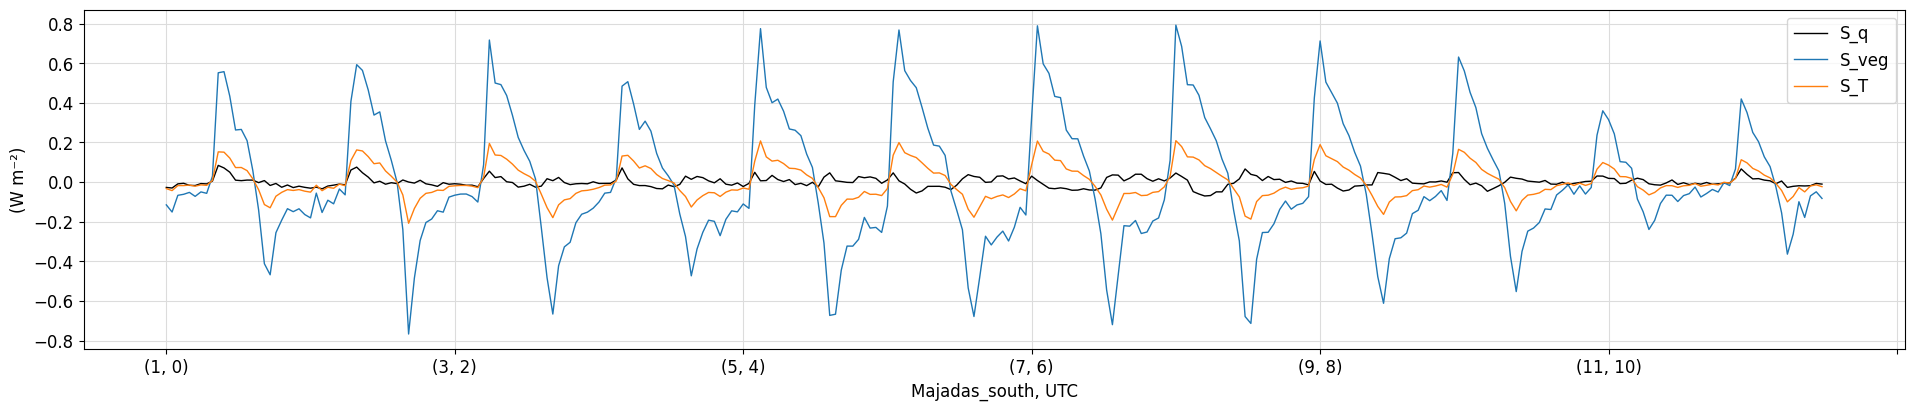

In [58]:
#Evaluate monthly diurnal cycles
MAJA_mcycle=MAJA.groupby([(MAJA.index.month),(MAJA.index.hour)]).mean()

# S_can components diurnal cycle
#Tidy figure for newsletter
fig, axs = plt.subplots(figsize=(23.5, 5))
MAJA_mcycle['S_q'].plot(ax=axs,color='k',label='S_q')
MAJA_mcycle['S_veg'].plot(ax=axs,label='S_veg')
MAJA_mcycle['S_T'].plot(ax=axs,label='S_T')
#MPOLE_mcycle['S_can'].plot(ax=axs,color='r',label='S_can')
axs.set_ylabel('(W m⁻²)')
axs.set_xlabel(station_name+', UTC')

box = axs.get_position()
axs.set_position([box.x0, box.y0 + box.height * 0.1,
box.width, box.height * 0.9])
axs.legend()

axs.grid(color ="gainsboro")
#axs.set_xticks(MPOLE_mcycle.index[::12])

Ahora nos vamos a adentrar en la validación vs observación. Es decir, en comparar los experimentos con los valores reales observados. Sacamos el mismo tipo de gráficas que hamos guardado antes, pero ahora salen las líneas de los experimentos y la de las observaciones. Para el caso de H y LE también sale la línea de las observaciones corregidas (esto antes estaba desactivado). 

Las imágenes se guardan con nombres 'Majadas_[variable]_[experimentos]_OBS.png'

Parece que aquí solo puedo sacar observaciones de H y LE no del resto. Esto debe ser de algún error de definición de parámetros, pero por ahora lo voy a ignorar porque al menos tengo H y LE, lo que más interesa.

In [59]:
MAJA_mcycle

H_DIF_REF  LE_DIF_REF  T2M_DIF_REF  W10M_DIF_REF  Q2M_DIF_REF  \
1  0  -14.749799    6.994305   276.610351      2.076255     0.004837   
   1   -6.245137    4.122915   276.022052      1.954054     0.004643   
   2   -3.835499    0.700772   275.723750      2.020634     0.004562   
   3   -3.431627    1.111773   275.454451      2.046675     0.004500   
   4   -4.218434    1.586334   275.261865      1.970860     0.004442   
...          ...         ...          ...           ...          ...   
12 19 -59.390662   47.475959   283.250392      2.722094     0.007621   
   20 -20.311335   12.648294   282.630764      2.642788     0.007432   
   21 -26.228680   17.267308   282.136318      2.684051     0.007231   
   22 -26.874229   16.003161   281.926054      2.705344     0.007121   
   23 -13.530588    3.643747   281.679398      2.641594     0.007083   

       HU2M_DIF_REF  CD_DIF_REF  CH_DIF_REF  RI_DIF_REF  FMU_DIF_REF  ...  \
1  0       0.956604    0.224187    0.224185   -0.020585          0.0  ...   
   1       0.953173    0.224187    0.224186   -0.025448          0.0  ...   
   2       0.953423    0.224187    0.224186   -0.026269          0.0  ...   
   3       0.954321    0.224187    0.224186   -0.021636          0.0  ...   
   4       0.952185    0.224187    0.224185   -0.022841          0.0  ...   
...             ...         ...         ...         ...          ...  ...   
12 19      0.961184    0.224187    0.224185   -0.002433          0.0  ...   
   20      0.973001    0.224187    0.224185   -0.005463          0.0  ...   
   21      0.976090    0.224187    0.224185   -0.004859          0.0  ...   
   22      0.973387    0.224187    0.224185   -0.004513          0.0  ...   
   23      0.981383    0.224187    0.224186   -0.007879          0.0  ...   

       Forc_DIR         ESAT            E   Forc_QA   Forc_SW      rhoa  \
1  0        0.0   824.114369   723.001670  0.005663  0.000000  1.245032   
   1        0.0   799.139267   699.921525  0.005490  0.000000  1.247141   
   2        0.0   776.537062   684.311255  0.005375  0.000000  1.249015   
   3        0.0   762.816306   676.356629  0.005316  0.000000  1.250363   
   4        0.0   752.179239   670.926013  0.005276  0.000000  1.251241   
...         ...          ...          ...       ...       ...       ...   
12 19       0.0  1266.959481  1095.727223  0.008405  0.082806  1.212058   
   20       0.0  1230.948913  1082.768268  0.008317  0.000000  1.214511   
   21       0.0  1178.922637  1064.654895  0.008194  0.000000  1.217606   
   22       0.0  1161.143901  1050.743901  0.008093  0.000000  1.219041   
   23       0.0  1149.050463  1048.040786  0.008075  0.000000  1.220084   

            S_T     S_veg       S_q     S_can  
1  0  -0.032591 -0.114821 -0.026806 -0.174218  
   1  -0.042861 -0.150959 -0.029715 -0.223534  
   2  -0.017535 -0.066541 -0.008809 -0.092886  
   3  -0.017511 -0.061481 -0.005949 -0.084941  
   4  -0.014981 -0.051829 -0.016237 -0.083046  
...         ...       ...       ...       ...  
12 19 -0.027759 -0.098915 -0.018309 -0.144984  
   20 -0.049275 -0.178210 -0.019362 -0.246847  
   21 -0.019367 -0.069476 -0.017987 -0.106829  
   22 -0.013663 -0.048839 -0.006523 -0.069025  
   23 -0.023005 -0.082316 -0.010007 -0.115328  

[288 rows x 314 columns]

In [20]:
# #Validation vs observations

# # dictionary of modeled vs observed column names. W10M actually refers to 3.5m diagnostics (sonic level)
# my_dict = {'H': 'H', 'LE': 'LE','ZLMO':'z_minus_d_over_L','T2M':'T2M','W10M':'ws','USTAR':'u_star','Q2M':'Q2M',
#            'SWD':'Forc_SW', 'SWU':'SWUP','LWD':'Forc_LW', 'LWU':'LWUP','CD':'Cd','CH':'Ch','CQ':'Cq','HU2M':'HU2M'}
# #for field in ['H','LE','T2M','HU2M','W10M','USTAR','Q2M','SWD', 'SWU','LWD', 'LWU','ZLMO','CD','CH']:

# print('These are the variables represented and stored in this code:')

# # names2 = ['sensible heat flux','latent heat flux','temperature at 2 meters','air relative humidity at 2 meters',
# #           'vertical wind at 10 meters','shear velocity','air specific humidity at 2 meters','downward short wave radiation','upward short wave radiation',
# #           'downward long wave radiation','upward long wave radiation','??']
# # units2 = ['W/m2','W/m2','K','-','m/s','m/s','kg/kg','W/m2','W/m2','W/m2','W/m2','??']
# # for field in ['H','LE','T2M','HU2M','W10M','USTAR','Q2M','SWD', 'SWU','LWD', 'LWU','ZLMO']:

# names2 = ['sensible heat flux','latent heat flux']
# units2 = ['W/m2','W/m2']

# m=0
# for field in ['H','LE']:
#  ncol = 4
#  print(field+': '+names2[m]+' ('+units2[m]+')')
#  my_list = [x for x in range(1,25)]
#  idx = pd.IndexSlice
#  fig = plt.figure(figsize=(18,15)) # estaba en (15,16)
#  axes = fig.subplots(nrows=4, ncols=3)
#  max_y = float('-inf')  # Inicializa el máximo global como infinito negativo ###
#  min_y = float('inf')  # Inicializa el mínimo global como infinito positivo ###
#  for i in [0,1,2,3]:
#   for j in [0,1,2]:
#     c=0
#     for exp in exps:
#      axes[i,j].plot(my_list,MAJA_mcycle[field+'_'+exp].loc[idx[3*i+j+1, 0:23]].values,label=field+'_'+exp,color=colors[c],linestyle=styles[c])
#      max_y = max(max_y, np.max(MAJA_mcycle[field+'_'+exp].loc[idx[3*i+j+1, 0:23]].values)) ###
#      min_y = min(min_y, np.min(MAJA_mcycle[field+'_'+exp].loc[idx[3*i+j+1, 0:23]].values)) ###
#      c+=1
#     axes[i,j].plot(my_list,MAJA_mcycle[my_dict[field]].loc[idx[3*i+j+1, 0:23]].values,label=field+'_obs',color=colors[c],linestyle=styles[c])
#     max_y = max(max_y, np.max(MAJA_mcycle[my_dict[field]].loc[idx[3*i+j+1, 0:23]].values)) ###
#     min_y = min(min_y, np.min(MAJA_mcycle[my_dict[field]].loc[idx[3*i+j+1, 0:23]].values)) ###
#     # if field=='H' or field=='LE':
#     #  axes[i,j].plot(my_list,MAJA_closing_mcycle[my_dict[field]+'_corrected'].loc[idx[3*i+j+1, 0:23]].values,label=field+'_obs_cor') # esto
#      # estaba quitado pero lo he vuelto a poner
#     #  ncol=5
#     axes[i,j].set_title(calendar.month_name[3*i+j+1])
#     axes[i,j].set_xlim([1,24])
#     axes[i,j].set_xticks([3,6,9,12,15,18,21])
#     axes[i,j].grid()
#  for i in [0,1,2,3]: ###
#   for j in [0,1,2]: ###
#     axes[i,j].set_ylim([min_y, max_y]) ###
#  lines, labels = fig.axes[-1].get_legend_handles_labels()
#  fig.legend(lines, labels, facecolor='lightgray', loc='lower center',framealpha=1,ncol=ncol) # framealpha=0.8
#  fig.suptitle(field+': '+names2[m]+' ('+units2[m]+') - Majadas 2019', fontsize=18, fontweight='bold')
#  m+=1
#  fig.tight_layout()
#  fig.subplots_adjust(bottom=0.06) # antes estaba hspace=0.5
#  fig.savefig(figs_path+short_name+'_'+field+'_all_OBS.png',facecolor='white')  # antes era '_'+exps[0]+'_'+exps[1]+'_OBS.png' en vez de '_all_OBS.png'
#  plt.close()

Esta próxima celda es nueva, te saca los regplot (scatter y line) de cada mes, en los que se ve el ajuste de cada simulación a las observaciones (no corregidas). Las figuras se guardan como 'Majadas_[H o LE]_OBSvs[exp].png'.

In [21]:
# my_dict = {'H': 'H', 'LE': 'LE'}

# for field in ['H','LE']:
#  c=0
#  for exp in exps:
#   my_list = [x for x in range(1,25)]
#   idx = pd.IndexSlice
#   fig = plt.figure(figsize=(18,15))
#   axes = fig.subplots(nrows=4, ncols=3)
#   for i in [0,1,2,3]:
#     for j in [0,1,2]:
#       x=MAJA_mcycle[my_dict[field]].loc[idx[3*i+j+1, 0:23]].values
#       y=MAJA_mcycle[field+'_'+exp].loc[idx[3*i+j+1, 0:23]].values
#       slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x,y)
#       sns.regplot(x=x, y=y, ax=axes[i,j],
#                  scatter_kws={"color":colors[c],"edgecolor":"black","alpha":1,"s":10}, # scatter_kws={"color":"none","edgecolor":"black","alpha":0.2,"s":10}
#                  line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope1,intercept1), "ls":"--", "color":colors[c]})
#       axes[i,j].legend()
#       axes[i,j].set_title(calendar.month_name[3*i+j+1])
#       axes[i,j].set_xlabel('obs')
#       axes[i,j].set_ylabel(exp)
#   c+=1
#   lines, labels = fig.axes[-1].get_legend_handles_labels()
#   fig.suptitle(+field+' Regplot: validation vs observations - Majadas 2019', fontsize=18, fontweight='bold')
#   fig.tight_layout()
#   fig.subplots_adjust(bottom=0.06)
#   fig.savefig(figs_path+short_name+'_'+field+'_OBSvs'+exp+'_NOTcor.png',facecolor='white')
#   plt.close()

Voy a intentar sacar las observaciones corregidas de H y LE pero no prometo nada:

Ahora el código incluía varias celdas con algunas gráficas mensuales repetidas. Decía "SEB Monthly graphs for BERMS" BERMS". ¿Qué es BERMS? ¿Otra estación? Las he pegado en el jupyter de basurilla y las he eliminado de aquí para no liarme.

Y bueno esta última celda no me he parado a mirar qué intenta hacer, pero tampoco lo está consiguiendo.

------------------------------------------------------------

Distintas agrupaciones de cosas:

OJO, aquí tenemos todo en MAJA, por eso no he definido más cosas (menos lo de closing, que directamente no lo tenemos).

In [60]:
MAJA_daily=MAJA.groupby([(MAJA.index.month),(MAJA.index.day)]).mean()
MAJA_hours=MAJA.groupby([(MAJA.index.month),(MAJA.index.day),(MAJA.index.hour)]).mean() # 8760
MAJA_mcycle=MAJA.groupby([(MAJA.index.month),(MAJA.index.hour)]).mean()

In [61]:
MAJA_daily_sum=MAJA.groupby([(MAJA.index.month),(MAJA.index.day)]).sum()

In [62]:
MAJA_energy=MAJA.groupby([(MAJA.index.month),(MAJA.index.day)]).sum()*1.8 

------------------------------------------------------------

# PROYECTO "SERIES TEMPORALES":
### Con una sola celda sacar todas las posibilidades que quiera cómodamente de gráficas TEMPORALES, que puedan abarcar todo el año o secciones, de los parámetros que quiera, con obs u obs_cor si quiero, acompañada de los forzamientos que quiera (uno o más), y representando los experimentos que quiera entre los 4 que tengo aquí (DIF o MEB, REF o DSL). Estaría bien poder representar también varios parámetros a la vez.

Dibujar H y LE frente a las observaciones pero día a día, en lugar del ciclo diurno mensual, y sobreponer en esas gráficas la precipitación (o tasa de precipitación, que es lo que tienes en la variable de Forzamiento FORC_Rain con la que se alimenta al modelo. Hacerlo para ambos, pero estaba propuesto para ver qué ocurre en Majadas en diciembre (DIF_REF rarete). 

TSWI: ver el ciclo diurno no tiene sentido, menor ver ciclos anuales (dato diario). Así que en esta gráfica saco de los principales parámetros a estudiar las gráficas de evolución anual (en dato por día). Con todos los experimentos juntos.

In [63]:
forcing_vars=['Forc_CO2','Forc_DIR','Forc_PS','Forc_RAIN','Forc_SNOW','Forc_WIND','Forc_DIR_SW','Forc_LW','Forc_QA','Forc_SCA_SW','Forc_TA']
forcing_names=['Near surface CO2 concentration', 'Wind direction', 'Atmospheric pression', 'Rain', 'Snow precipitation', 'Wind speed',
               'Direct short-wave radiation', 'Long-wave radiation', 'Atmospheric humidity', 'Diffuse short-wave radiation', 'Atmospheric temperature']
forcing_units=['kg/m3', 'W/m2', 'Pa', 'kg/m2/s', 'kg/m2/s', 'm/s', 'W/m2', 'W/m2', 'kg/kg', 'W/m2', 'K']
forcing_units_2=['N/A', 'kJ/m2', 'N/A', 'N/A', 'N/A', 'N/A', 'kJ/m2', 'kJ/m2', 'N/A', 'kJ/m2', 'N/A']

# Creo que el diccionario solo es necesario aplicarlo para las observaciones (sin corregir, claro)
my_dict = {'H': 'H', 'LE': 'LE','ZLMO':'z_minus_d_over_L','T2M':'T2M','W10M':'ws','USTAR':'u_star','Q2M':'Q2M',
           'SWD':'Forc_SW', 'SWU':'SWUP','LWD':'Forc_LW', 'LWU':'LWUP','CD':'Cd','CH':'Ch','CQ':'Cq','HU2M':'HU2M'}

field_vars = ['TSWI1','TSWI2','TSWI3','TSWI4','H','LE','LEV','LEG','T2M','W10M','HU2M','RI','FMU','FMV','TG1','SWD','SWU','LWD','LWU','USTAR','Q2M','ZLMO']
# field_names = ['total soil wetness index 1','total soil wetness index 2','total soil wetness index 3','total soil wetness index 4', 
#           'sensible heat flux','latent heat flux','vegetation evaporation heat flux','ground evaporation heat flux','temperature at 2 meters',
#           'vertical wind at 10 meters','air relative humidity at 2 meters','averaged richardson number','zonal wind stress',
#           'meridian wind stress','surface temperature 1','downward short wave radiation','upward short wave radiation',
#           'downward long wave radiation','upward long wave radiation','shear velocity','air specific humidity at 2 meters','??']
field_units = ['-','-','-','-','W/m2','W/m2','W/m2','W/m2','K','m/s','-','-','Pa','Pa','K','W/m2','W/m2','W/m2','W/m2','m/s','kg/kg','??']

field_names = ['total soil wetness index 1','total soil wetness index 2','total soil wetness index 3','total soil wetness index 4', 
          'sensible heat','latent heat','vegetation evaporation heat','ground evaporation heat','temperature at 2 meters',
          'vertical wind at 10 meters','air relative humidity at 2 meters','averaged richardson number','zonal wind stress',
          'meridian wind stress','surface temperature 1','downward short wave radiation','upward short wave radiation',
          'downward long wave radiation','upward long wave radiation','shear velocity','air specific humidity at 2 meters','??']
field_units_2 = ['N/A','N/A','N/A','N/A','kJ/m2','kJ/m2','kJ/m2','kJ/m2','N/A','N/A','N/A','N/A','N/A','N/A','N/A','kJ/m2','kJ/m2','kJ/m2','kJ/m2','N/A','N/A','N/A']


exps=['DIF_REF', 'DIF_DSL', 'MEB_DSL']
# ['DIF_REF', 'DIF_DSL', 'MEB_REF', 'MEB_DSL', 'obs', 'obs_cor', 'forc']
colors = ['deepskyblue', 'blue', 'orange', 'crimson', 'gray', 'black', 'grey'] # no me decido entre grey y lightblue
styles = ['solid', 'dashed', 'solid', 'dashed', 'dotted', 'dotted', 'solid']

MAJA: paramentros de las simulaciones, observaciones y forzamientos cada media hora (valores base)\
MAJA_hours: MAJA horario\
MAJA_daily: MAJA diario\
MAJA_mcycle: MAJA en promedio mensual de cada hora (24 horas para cada mes)\
MAJA_daily_filt: MAJA_daily pero solo con los valores positivos, por ahora le he dado poco uso y puede que esté mal

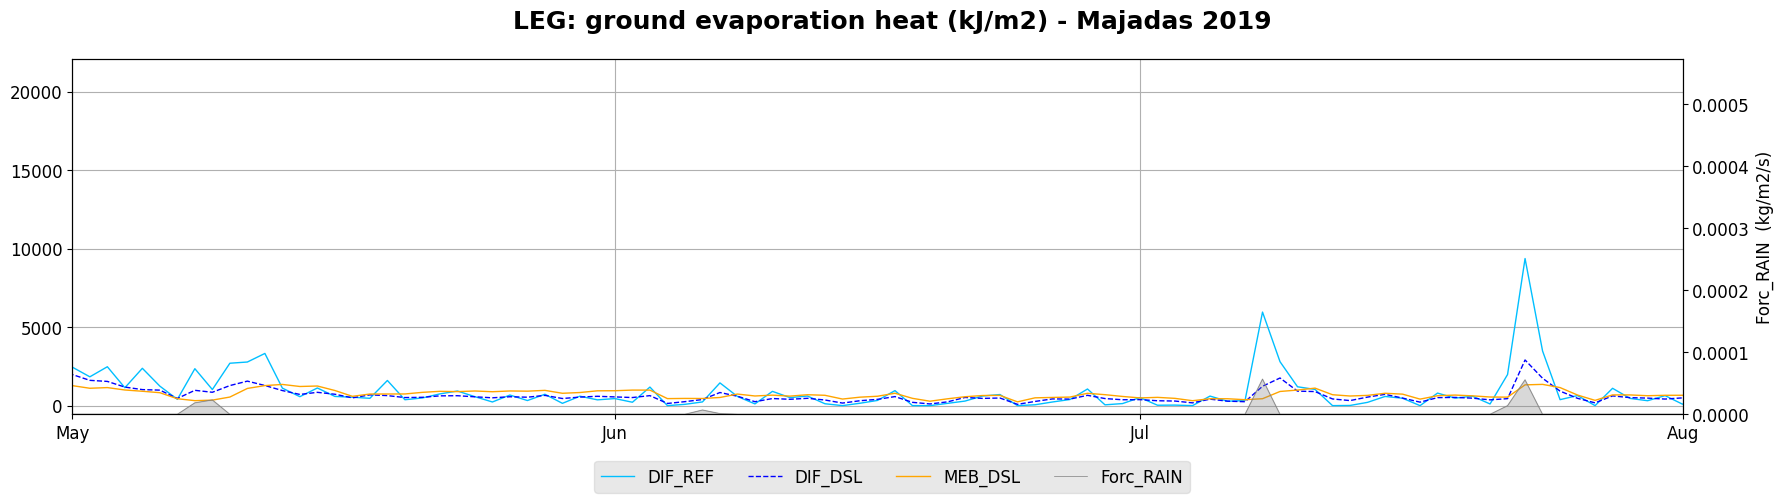

In [64]:
campo = 7 # posición en field_vars lo voy a hacer para que por ahora salga de uno en uno (H=4)
add_forc = True # añadir o no un forzamiento
forzamiento = 3 # se podría hacer para otro forzamiento más pero no lo recomiendo, porque sería tener 3 ejes y en una misma gráfica (Forc_RAIN=3)
experiments = [0,1,2] # Posiciones. Por si no quiero representarlos todos
# experiments = ['DIF_REF', 'DIF_DSL', 'MEB_REF', 'MEB_DSL']

month_interv = [5, 7] # Intervalo de meses (Enero = 1). Ambos inclusive
# day_interv = [1, 15] # ESTÁ PENDIENTE, hacer para dentro de un solo mes supongo? por ahora

observation = True # Para ver o no las observaciones de H y LE

# graph_type = 'diario'
# graph_type = 'horario'
# graph_type = 'promedio mensual'
# graph_type = 'boxplot mensual'
# graph_type = 'diario acumulado'
graph_type = 'energia'

########## Ahora ya la figura, esto no se debería necesitar editar:
meses = [calendar.month_abbr[i] for i in range(1, 13)] + ['Jan']
dias_por_mes = [calendar.monthrange(2019, i)[1] for i in range(1, 13)] 
dias_por_mes.insert(0, 0)

if graph_type == 'diario':
  posiciones_meses = np.cumsum(dias_por_mes)
  y = MAJA_daily
  # y3 = MAJA_closing_daily
elif graph_type == 'horario':
  posiciones_meses = np.cumsum(dias_por_mes)*24
  y = MAJA_hours
elif graph_type == 'promedio mensual':
  cycle = [24] * 12
  cycle.insert(0, 0)
  posiciones_meses = np.cumsum(cycle)
  y = MAJA_mcycle
elif graph_type == 'diario acumulado':
  posiciones_meses = np.cumsum(dias_por_mes)
  y = MAJA_daily_sum
  # y3 = MAJA_closing_mcycle
elif graph_type == 'energia':
  posiciones_meses = np.cumsum(dias_por_mes)
  y = MAJA_energy
  y2 = MAJA_daily
elif graph_type == 'boxplot mensual':
  posiciones_meses = np.cumsum(dias_por_mes)
  y = MAJA_daily
  y2 = [grupo[field_vars[campo]+'_'+exps[experiments[0]]].tolist() for _, grupo in MAJA_daily.groupby(level=0)]


fig, ax1 = plt.subplots(figsize=(18,5))

minimos, maximos = [], []
if graph_type == 'boxplot mensual':
  bp=ax1.boxplot(y2, positions=posiciones_meses[1:]-15, widths=6, patch_artist = True, boxprops = dict(facecolor = colors[experiments[0]]))
  fig.legend([bp["boxes"][0]], [exps[experiments[0]]], facecolor='lightgray',framealpha=0.5, bbox_to_anchor=(0.4, 0.1))
else:
  # minimos, maximos = [], []
  for exp in experiments:
    ax1.plot(y[field_vars[campo]+'_'+exps[exp]].values, label=exps[exp], color=colors[exp], linestyle=styles[exp], linewidth=1)
    minimos.append(np.min(y[field_vars[campo]+'_'+exps[exp]].values))
    maximos.append(np.max(y[field_vars[campo]+'_'+exps[exp]].values))
ax1.grid(True)

if add_forc == True:
  ax2 = ax1.twinx()
  ax2.set_ylabel(forcing_vars[forzamiento]+'  ('+forcing_units[forzamiento]+')')
  ax2.plot(y2[forcing_vars[forzamiento]].values, color=colors[6], label=forcing_vars[forzamiento], linewidth=0.5)
  ax2.fill_between(np.arange(0,len(y2)),y2[forcing_vars[forzamiento]].values, color=colors[6], alpha=0.3)
  ax2.set_ylim([np.min(y2[forcing_vars[forzamiento]].values), np.max(y2[forcing_vars[forzamiento]].values)]) ### a ver si me convence

if observation == True and field_vars[campo] in my_dict:
  ax1.plot(y[my_dict[field_vars[campo]]].values,label='obs',color=colors[5],linestyle=styles[4]) # color=colors[4]
  minimos.append(np.min(y[my_dict[field_vars[campo]]].values))
  maximos.append(np.max(y[my_dict[field_vars[campo]]].values))

ax1.set_ylim([np.min(minimos), np.max(maximos)]) ### a ver si me convence

fig.legend(facecolor='lightgray',framealpha=0.5, ncol=6, loc='lower center') # loc='lower center'
# ax1.legend(facecolor='lightgray',framealpha=0.5, ncol=5) #, bbox_to_anchor=(0.44, -0.1))
fig.suptitle(field_vars[campo]+': '+field_names[campo]+' ('+field_units_2[campo]+') - Majadas 2019', fontsize=18, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(bottom=0.17)

plt.xticks(posiciones_meses, meses)
plt.xlim([posiciones_meses[month_interv[0] - 1],posiciones_meses[month_interv[1]]]) # Esto para sacar meses concretos

# if graph_type != 'promedio mensual':
#   plt.xlim([posiciones_meses[month_interv[0] - 1],posiciones_meses[month_interv[1]]])

# fig.savefig(figs_path+station_name+'_timeseries.png',facecolor='white')
plt.show()
plt.close()

# ESTA ES LA QUE SE PUEDE EDITAR:

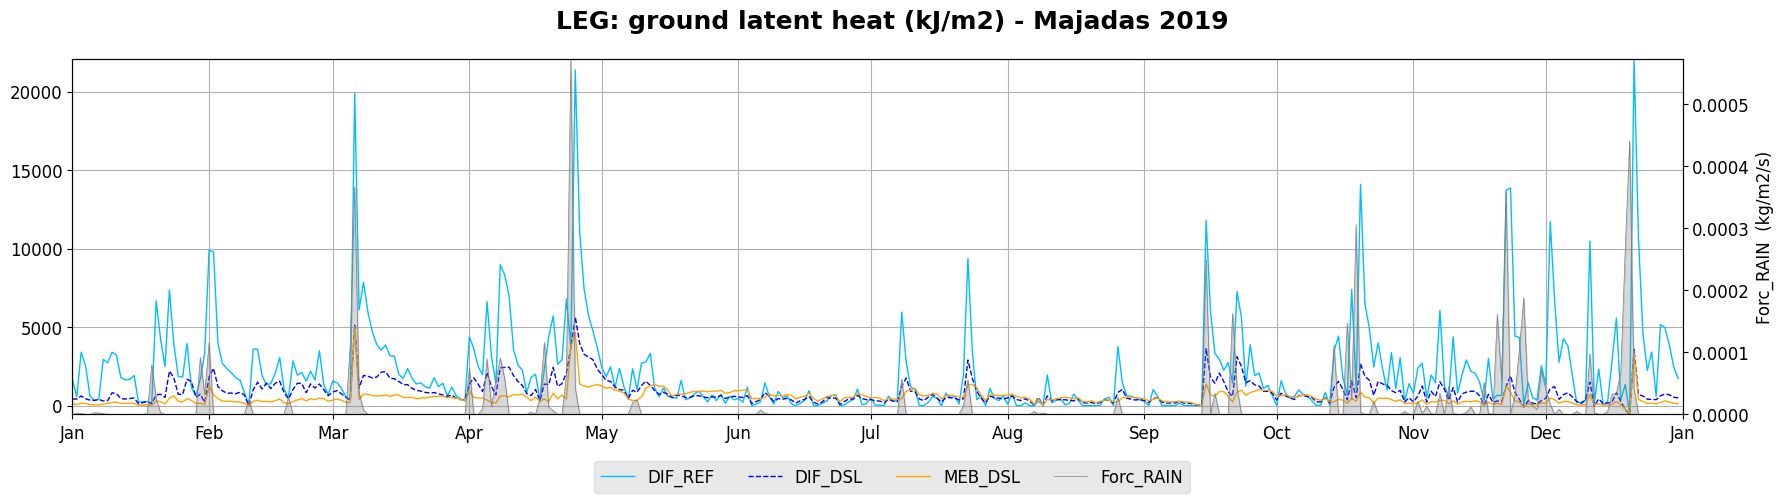

In [69]:
campo = 7 # posición en field_vars lo voy a hacer para que por ahora salga de uno en uno (H=4)
add_forc = True # añadir o no un forzamiento
forzamiento = 3 # se podría hacer para otro forzamiento más pero no lo recomiendo, porque sería tener 3 ejes y en una misma gráfica (Forc_RAIN=3)
experiments = [0,1,2] # Posiciones. Por si no quiero representarlos todos
# experiments = ['DIF_REF', 'DIF_DSL', 'MEB_REF', 'MEB_DSL']

month_interv = [1,12] # Intervalo de meses (Enero = 1). Ambos inclusive
# day_interv = [1, 15] # ESTÁ PENDIENTE, hacer para dentro de un solo mes supongo? por ahora

observation = False # Para ver o no las observaciones de H y LE

# graph_type = 'diario'
# graph_type = 'horario'
# graph_type = 'promedio mensual'
# graph_type = 'boxplot mensual'
# graph_type = 'diario acumulado'
graph_type = 'energia'

########## Ahora ya la figura, esto no se debería necesitar editar:
meses = [calendar.month_abbr[i] for i in range(1, 13)] + ['Jan']
dias_por_mes = [calendar.monthrange(2019, i)[1] for i in range(1, 13)] 
dias_por_mes.insert(0, 0)

if graph_type == 'diario':
  posiciones_meses = np.cumsum(dias_por_mes)
  y = MAJA_daily
  # y3 = MAJA_closing_daily
elif graph_type == 'horario':
  posiciones_meses = np.cumsum(dias_por_mes)*24
  y = MAJA_hours
elif graph_type == 'promedio mensual':
  cycle = [24] * 12
  cycle.insert(0, 0)
  posiciones_meses = np.cumsum(cycle)
  y = MAJA_mcycle
elif graph_type == 'diario acumulado':
  posiciones_meses = np.cumsum(dias_por_mes)
  y = MAJA_daily_sum
  # y3 = MAJA_closing_mcycle
elif graph_type == 'energia':
  posiciones_meses = np.cumsum(dias_por_mes)
  y = MAJA_energy
  y2 = MAJA_daily
elif graph_type == 'boxplot mensual':
  posiciones_meses = np.cumsum(dias_por_mes)
  y = MAJA_daily
  y2 = [grupo[field_vars[campo]+'_'+exps[experiments[0]]].tolist() for _, grupo in MAJA_daily.groupby(level=0)]


fig, ax1 = plt.subplots(figsize=(18,5))

minimos, maximos = [], []
if graph_type == 'boxplot mensual':
  bp=ax1.boxplot(y2, positions=posiciones_meses[1:]-15, widths=6, patch_artist = True, boxprops = dict(facecolor = colors[experiments[0]]))
  fig.legend([bp["boxes"][0]], [exps[experiments[0]]], facecolor='lightgray',framealpha=0.5, bbox_to_anchor=(0.4, 0.1))
else:
  # minimos, maximos = [], []
  for exp in experiments:
    ax1.plot(y[field_vars[campo]+'_'+exps[exp]].values, label=exps[exp], color=colors[exp], linestyle=styles[exp], linewidth=1)
    minimos.append(np.min(y[field_vars[campo]+'_'+exps[exp]].values))
    maximos.append(np.max(y[field_vars[campo]+'_'+exps[exp]].values))
ax1.grid(True)

if add_forc == True:
  ax2 = ax1.twinx()
  ax2.set_ylabel(forcing_vars[forzamiento]+'  ('+forcing_units[forzamiento]+')')
  ax2.plot(y2[forcing_vars[forzamiento]].values, color=colors[6], label=forcing_vars[forzamiento], linewidth=0.5)
  ax2.fill_between(np.arange(0,len(y2)),y2[forcing_vars[forzamiento]].values, color=colors[6], alpha=0.3)
  ax2.set_ylim([np.min(y2[forcing_vars[forzamiento]].values), np.max(y2[forcing_vars[forzamiento]].values)]) ### a ver si me convence

if observation == True and field_vars[campo] in my_dict:
  ax1.plot(y[my_dict[field_vars[campo]]].values,label='obs',color=colors[5],linestyle=styles[4]) # color=colors[4]
  minimos.append(np.min(y[my_dict[field_vars[campo]]].values))
  maximos.append(np.max(y[my_dict[field_vars[campo]]].values))

ax1.set_ylim([np.min(minimos), np.max(maximos)]) ### a ver si me convence

fig.legend(facecolor='lightgray',framealpha=0.5, ncol=6, loc='lower center') # loc='lower center'
# ax1.legend(facecolor='lightgray',framealpha=0.5, ncol=5) #, bbox_to_anchor=(0.44, -0.1))
fig.suptitle(field_vars[campo]+': ground latent heat ('+field_units_2[campo]+') - Majadas 2019', fontsize=18, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(bottom=0.17)

plt.xticks(posiciones_meses, meses)
plt.xlim([posiciones_meses[month_interv[0] - 1],posiciones_meses[month_interv[1]]]) # Esto para sacar meses concretos

# if graph_type != 'promedio mensual':
#   plt.xlim([posiciones_meses[month_interv[0] - 1],posiciones_meses[month_interv[1]]])

# fig.savefig(figs_path+station_name+'_timeseries.png',facecolor='white')
plt.show()
plt.close()

# PROYECTO "REGPLOTS":
### Con una sola celda sacar todas las posibilidades que quiera cómodamente de gráficas REGPLOT MENSUALES, de los parámetros que quiera, con obs u obs_cor, para el experimento que quiera, y pudiendo escoger si quiero representar solo los valores positivos de las simulaciones (¿u observaciones?).

Hago lo mismo de antes pero solo para H y eliminando los valores negativos (por la noche). Las figuras se guardan como 'Majadas_H_OBSvs[exp]_day.png'.

[Ojo, no se llama closure rate a los scatter plots, eso es otra cosa. Les podemos llamar Scatterplots mismamente. Y al representarlos usar todos los puntos del mes (datos diarios?) no el promedio de cada hora.]

[Por tanto, hacer los scatter plots pero filtrando solo los datos que ocurren durante el día (solo los valores positivos). Esto en el caso de H. No haría falta para LE.]

Hecho está, ahora tengo que entenderlo, interpretarlo y saber sacarle sentido o concluir que no era buena idea.

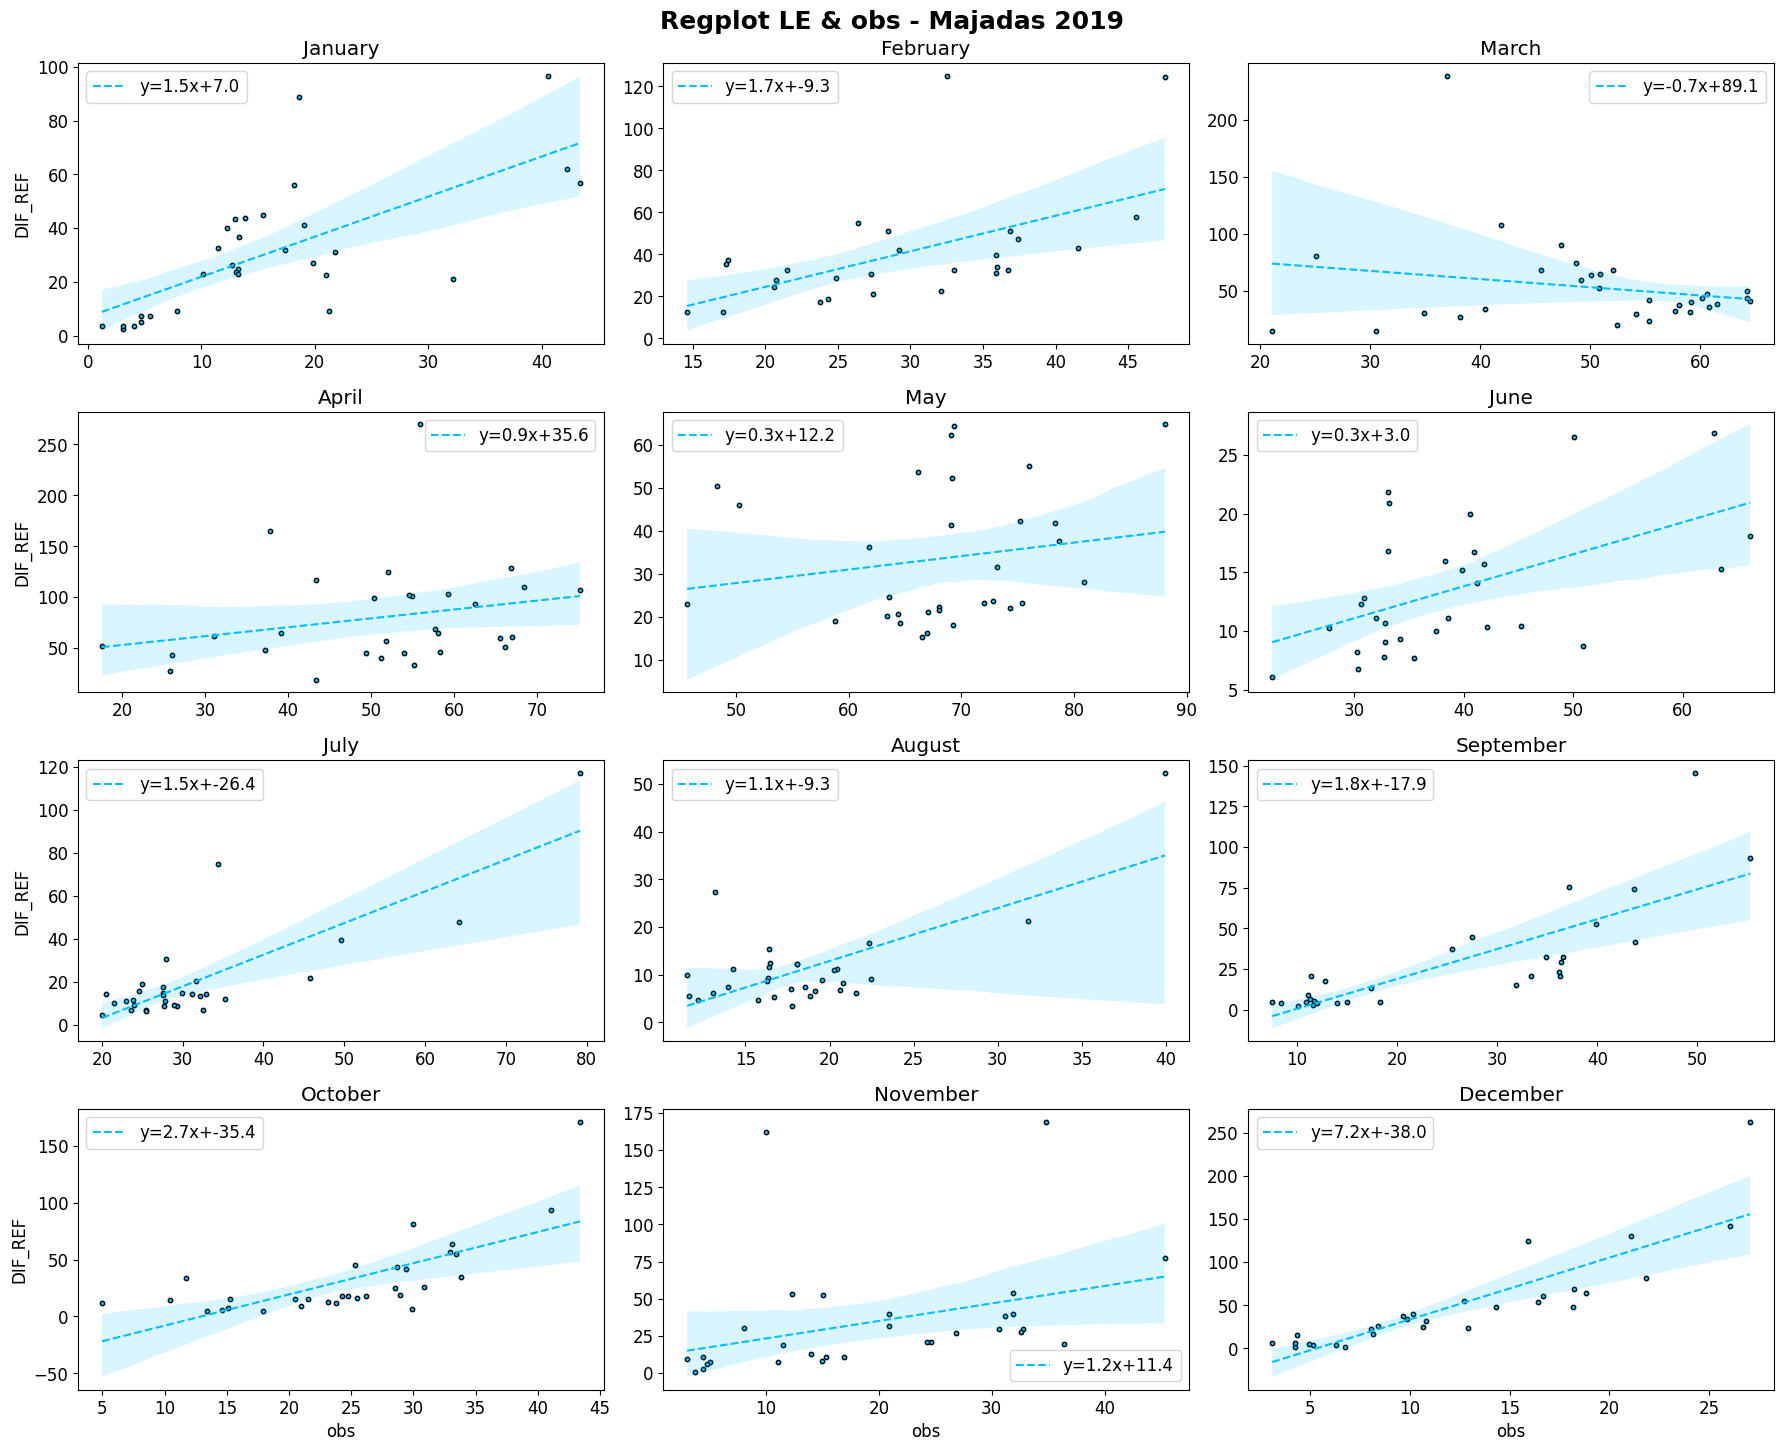

In [27]:
campo = 5 # posición en field_vars (H=4, LE=5)
exp = 0 # Posición del experimento ['DIF_REF', 'DIF_DSL', 'MEB_REF', 'MEB_DSL']

corrected = False # NO TENGO CORRECCIONES EN MAJADAS

# graph_type = 'promedio mensual'
# graph_type = 'diario'
graph_type = 'diario positivos'

########## Ahora ya la figura, esto no se debería necesitar editar:
fig = plt.figure(figsize=(18,15))
axes = fig.subplots(nrows=4, ncols=3)

for i in [0,1,2,3]:
  for j in [0,1,2]:
      if graph_type == 'promedio mensual':
        y=MAJA_mcycle[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values
        if corrected == True:
          x=MAJA_closing_mcycle[field_vars[campo]+'_corrected'].loc[3*i+j+1].values
        else:
          x=MAJA_mcycle[field_vars[campo]].loc[3*i+j+1].values
      elif graph_type == 'diario':
        y=MAJA_daily[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values
        if corrected == True:
          x=MAJA_closing_daily[field_vars[campo]+'_corrected'].loc[3*i+j+1].values
        else:
          x=MAJA_daily[field_vars[campo]].loc[3*i+j+1].values
      elif graph_type == 'diario positivos':
        MAJA_daily_filt = MAJA_daily.loc[MAJA_daily[field_vars[campo]+'_'+exps[exp]] >= 0]
        indices_a_eliminar = MAJA_daily.index.difference(MAJA_daily_filt.index)
        y=MAJA_daily_filt[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values
        if corrected == True:
          MAJA_closing_daily_filt = MAJA_closing_daily.drop(indices_a_eliminar)
          x=MAJA_closing_daily_filt[field_vars[campo]+'_corrected'].loc[3*i+j+1].values
        else:
          x=MAJA_daily_filt[field_vars[campo]].loc[3*i+j+1].values

        if corrected == True:
          xlabel = 'obs_cor'
        else:
          xlabel = 'obs'

      slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x,y)
      sns.regplot(x=x, y=y, ax=axes[i,j],
                 scatter_kws={"color":colors[exp],"edgecolor":"black","alpha":1,"s":10},
                 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope1,intercept1), "ls":"--", "color":colors[exp]})
      axes[i,j].legend()
      axes[i,j].set_title(calendar.month_name[3*i+j+1])
      if j == 0:
        axes[i,j].set_ylabel(exps[exp])
      if i == 3:
        axes[i,j].set_xlabel(xlabel)
lines, labels = fig.axes[-1].get_legend_handles_labels()

fig.suptitle('Regplot '+field_vars[campo]+' & '+xlabel+' - Majadas 2019', fontsize=18, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(bottom=0.06)
# fig.savefig(figs_path+station_name+'_regplot.png',facecolor='white')
plt.show()
plt.close()

# PROYECTO "GRÁFICAS MENSUALES":
### Con una sola celda sacar todas las posibilidades que quiera cómodamente de gráficas MENSUALES, de los parámetros que quiera, con obs U obs_cor o ambas, para los experimentos que quiera, y ya sea con datos diarios, horarios o promedios mensuales horarios.

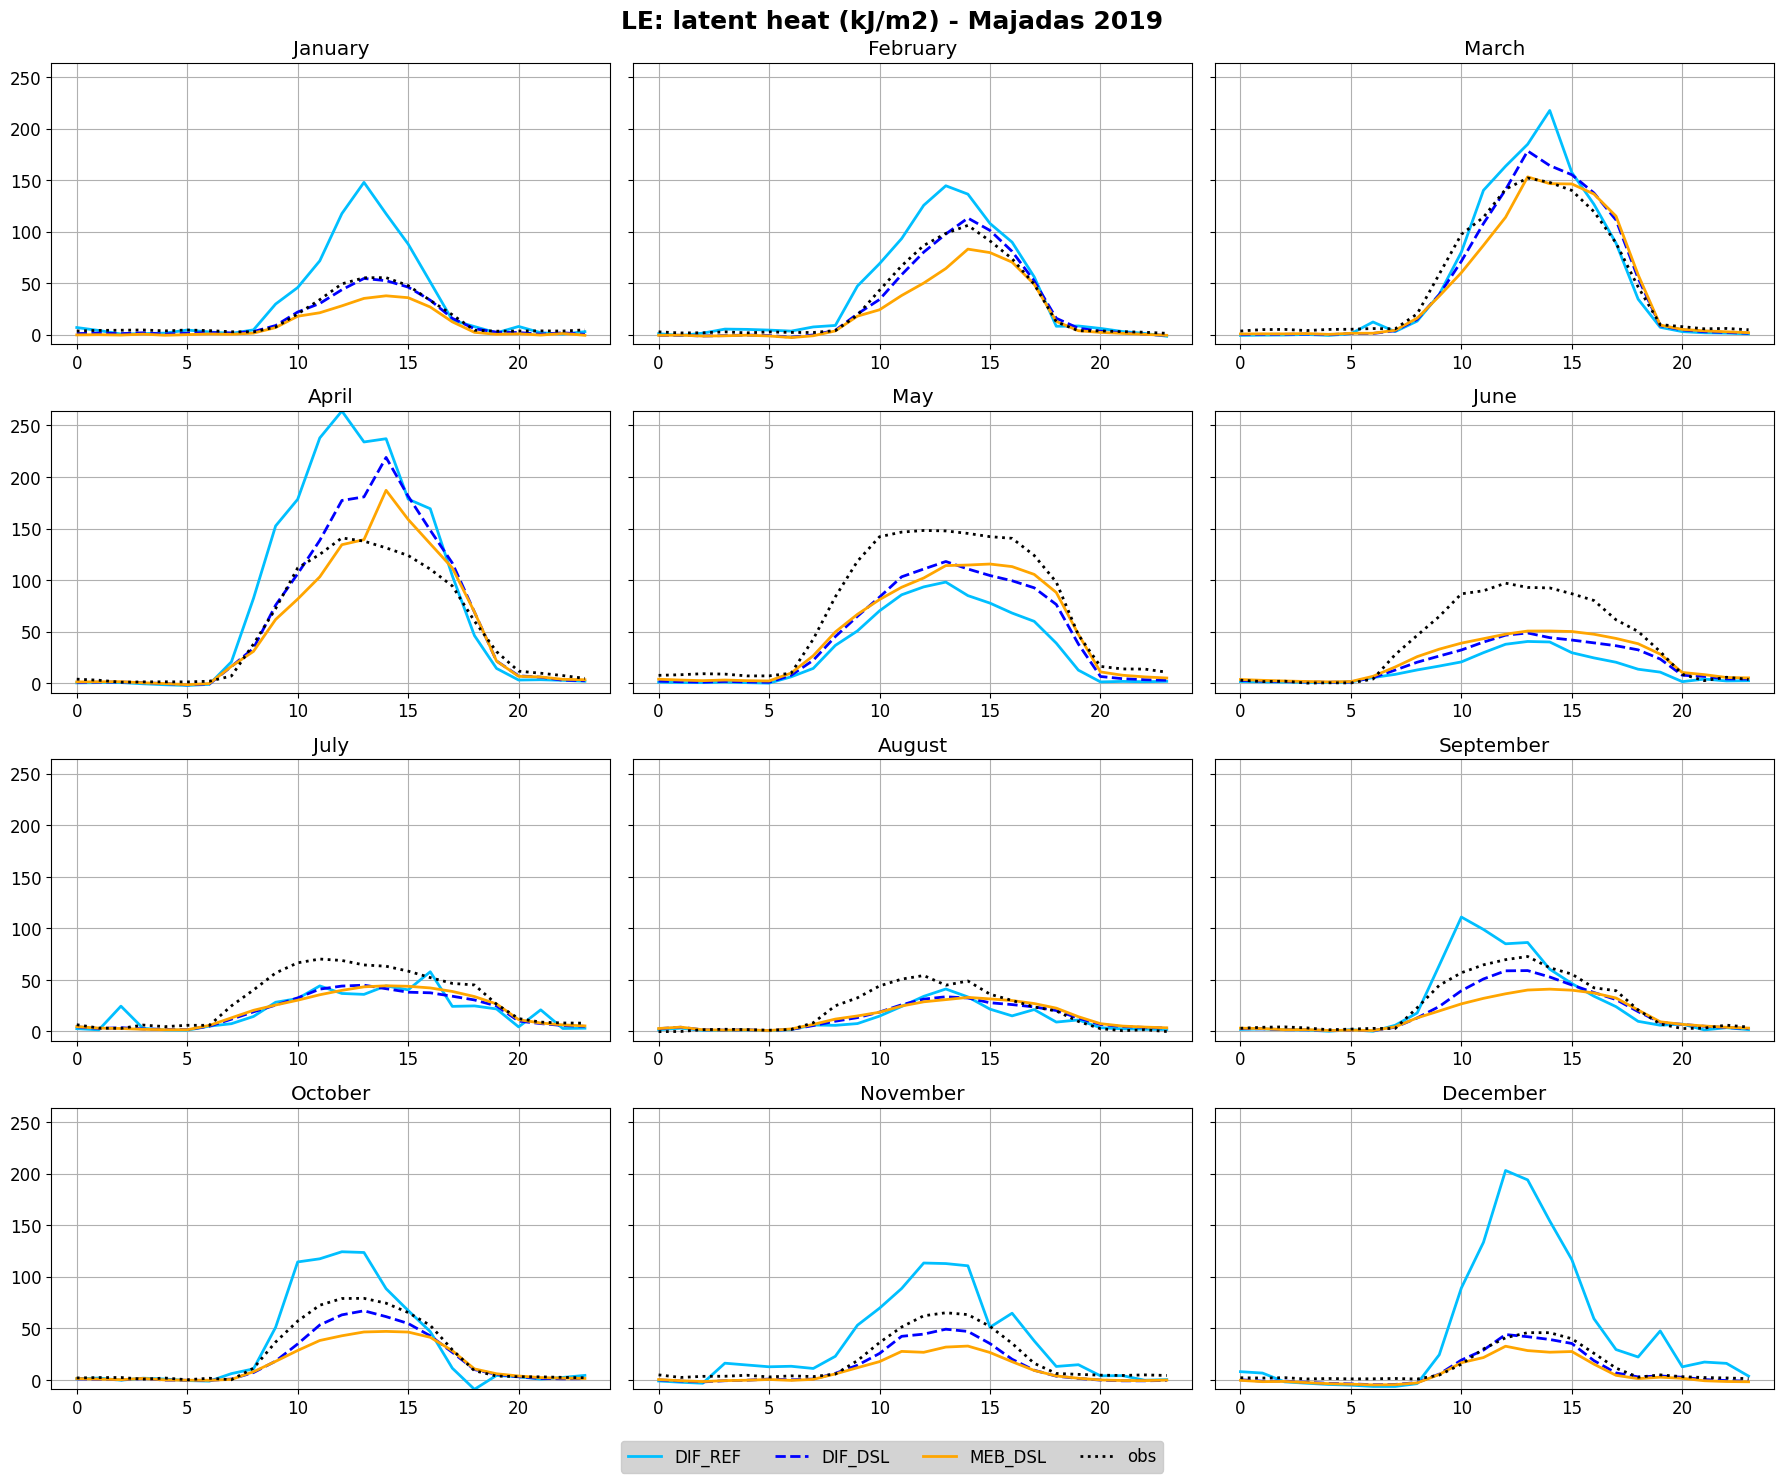

In [28]:
campo = 5 # posición en field_vars lo voy a hacer para que por ahora salga de uno en uno (H=4)
add_forc = False # añadir o no un forzamiento, por ahora no interesa mucho quizás, porque es mejor verlo en las series temporales
forzamiento = 6 # se podría hacer para otro forzamiento más pero no lo recomiendo, porque sería tener 3 ejes y en una misma gráfica (Forc_RAIN=3)
experiments = [0, 1, 2] # Posiciones. ['DIF_REF', 'DIF_DSL', 'MEB_REF', 'MEB_DSL']

matplotlib.rcParams['lines.linewidth'] = 2

observation = True # Para ver o no las observaciones de H y LE
corrected = False
rescalado = True # en principio siempre lo vamos a querer True

# graph_type = 'diario'
# graph_type = 'horario'
graph_type = 'promedio mensual'
# graph_type = 'diario acumulado'
# graph_type = 'energia'

########## Ahora ya la figura, esto no se debería necesitar editar:
fig = plt.figure(figsize=(18,15))
axes = fig.subplots(nrows=4, ncols=3)
minimos, maximos = [], []

if graph_type == 'diario':
  y = MAJA_daily
  # y3 = MAJA_closing_daily
if graph_type == 'horario':
  y = MAJA_hours
if graph_type == 'promedio mensual':
  y = MAJA_mcycle
  # y3 = MAJA_closing_mcycle
if graph_type == 'diario acumulado':
  y = MAJA_daily_sum
if graph_type == 'energia':
  y = MAJA_energy

for i in [0,1,2,3]:
  for j in [0,1,2]:
    for exp in experiments:
      axes[i,j].plot(y[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values,label=exps[exp],color=colors[exp],linestyle=styles[exp])
      minimos.append(np.min(y[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values))
      maximos.append(np.max(y[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values))

    if j != 0:
      axes[i,j].set_yticklabels([])
    
    axes[i,j].set_title(calendar.month_name[3*i+j+1])
    axes[i,j].grid(True)

    if add_forc == True:
      ax2 = axes[i,j].twinx()
      ax2.plot(y[forcing_vars[forzamiento]].loc[3*i+j+1].values, color=colors[6], label=forcing_vars[forzamiento]+' ('+forcing_units_2[forzamiento]+')', linewidth=0.5)
      ax2.fill_between(np.arange(0,len(y[forcing_vars[forzamiento]].loc[3*i+j+1].values)),y[forcing_vars[forzamiento]].loc[3*i+j+1].values, color=colors[6], alpha=0.2)
      ax2.set_ylim([np.min(y[forcing_vars[forzamiento]].values), np.max(y[forcing_vars[forzamiento]].values)]) ### a ver si me convence
      if j != 2:
        ax2.set_yticklabels([])

    if observation == True and field_vars[campo] in my_dict:
      axes[i,j].plot(y[my_dict[field_vars[campo]]].loc[3*i+j+1].values,label='obs',color=colors[5],linestyle=styles[4]) # ,color=colors[4]
      maximos.append(np.max(y[my_dict[field_vars[campo]]].loc[3*i+j+1].values))
      minimos.append(np.min(y[my_dict[field_vars[campo]]].loc[3*i+j+1].values))
      if field_vars[campo] in ('H', 'LE') and corrected == True and graph_type != 'horario':
        axes[i,j].plot(y3[field_vars[campo]+'_corrected'].loc[3*i+j+1].values,label='obs_cor',color=colors[5],linestyle=styles[5])
        maximos.append(np.max(y3[field_vars[campo]+'_corrected'].loc[3*i+j+1].values))
        minimos.append(np.min(y3[field_vars[campo]+'_corrected'].loc[3*i+j+1].values))
        axes[i,j].fill_between(range(0,len(y[my_dict[field_vars[campo]]].loc[3*i+j+1].values)),y[field_vars[campo]].loc[3*i+j+1].values, y3[field_vars[campo]+'_corrected'].loc[3*i+j+1].values, color='gray', alpha=0.15)

if rescalado == True:
  for i in [0,1,2,3]:
    for j in [0,1,2]:
      axes[i,j].set_ylim([np.min(minimos), np.max(maximos)])

lines, labels = fig.axes[1].get_legend_handles_labels()
fig.legend(lines, labels, facecolor='lightgray', loc='lower center',framealpha=1, ncol=6)
fig.suptitle(field_vars[campo]+': '+field_names[campo]+' ('+field_units_2[campo]+') - Majadas 2019', fontsize=18, fontweight='bold')

if add_forc == True:
  lines, labels = fig.axes[-1].get_legend_handles_labels()
  fig.legend(lines, labels, facecolor='lightgray', loc='lower right',framealpha=1, ncol=1)

fig.tight_layout()
fig.subplots_adjust(bottom=0.06)
#  fig.savefig(figs_path+station_name+'_months.png',facecolor='white')
plt.show()
plt.close()

# ESTA ES LA QUE SE PUEDE EDITAR:

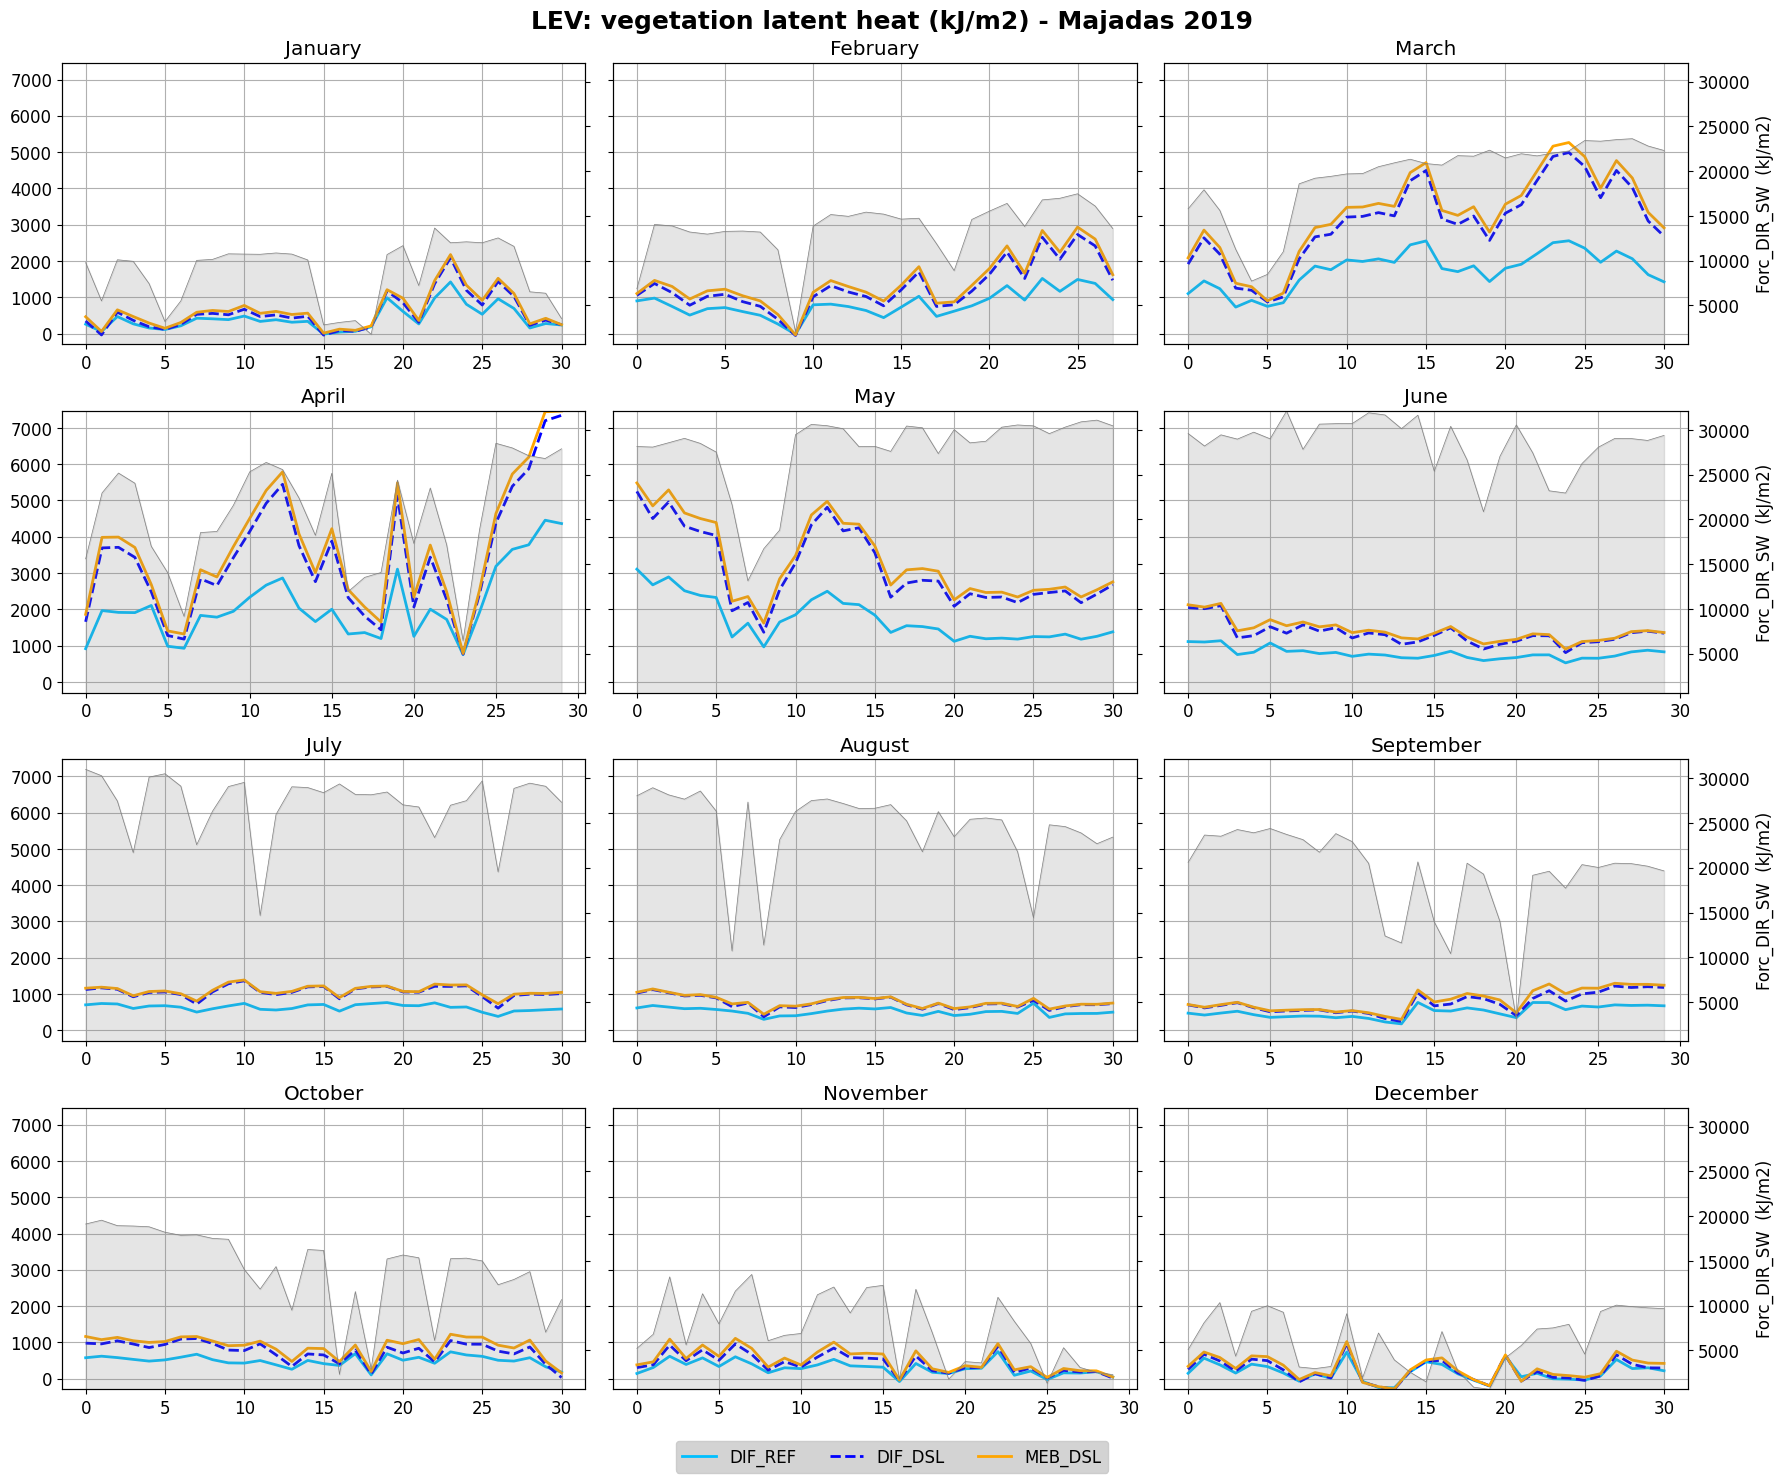

In [74]:
campo = 6 # posición en field_vars lo voy a hacer para que por ahora salga de uno en uno (H=4)
add_forc = True # añadir o no un forzamiento, por ahora no interesa mucho quizás, porque es mejor verlo en las series temporales
forzamiento = 6 # se podría hacer para otro forzamiento más pero no lo recomiendo, porque sería tener 3 ejes y en una misma gráfica (Forc_RAIN=3)
experiments = [0, 1, 2] # Posiciones. ['DIF_REF', 'DIF_DSL', 'MEB_REF', 'MEB_DSL']

matplotlib.rcParams['lines.linewidth'] = 2

observation = True # Para ver o no las observaciones de H y LE
corrected = False
rescalado = True # en principio siempre lo vamos a querer True

# graph_type = 'diario'
# graph_type = 'horario'
# graph_type = 'promedio mensual'
# graph_type = 'diario acumulado'
graph_type = 'energia'

########## Ahora ya la figura, esto no se debería necesitar editar:
fig = plt.figure(figsize=(18,15))
axes = fig.subplots(nrows=4, ncols=3)
minimos, maximos = [], []

if graph_type == 'diario':
  y = MAJA_daily
  # y3 = MAJA_closing_daily
if graph_type == 'horario':
  y = MAJA_hours
if graph_type == 'promedio mensual':
  y = MAJA_mcycle
  # y3 = MAJA_closing_mcycle
if graph_type == 'diario acumulado':
  y = MAJA_daily_sum
if graph_type == 'energia':
  y = MAJA_energy

for i in [0,1,2,3]:
  for j in [0,1,2]:
    for exp in experiments:
      axes[i,j].plot(y[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values,label=exps[exp],color=colors[exp],linestyle=styles[exp])
      minimos.append(np.min(y[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values))
      maximos.append(np.max(y[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values))

    if j != 0:
      axes[i,j].set_yticklabels([])
    
    axes[i,j].set_title(calendar.month_name[3*i+j+1])
    axes[i,j].grid(True)

    if add_forc == True:
      ax2 = axes[i,j].twinx()
      ax2.plot(y[forcing_vars[forzamiento]].loc[3*i+j+1].values, color=colors[6], label=forcing_vars[forzamiento]+' ('+forcing_units_2[forzamiento]+')', linewidth=0.5)
      ax2.fill_between(np.arange(0,len(y[forcing_vars[forzamiento]].loc[3*i+j+1].values)),y[forcing_vars[forzamiento]].loc[3*i+j+1].values, color=colors[6], alpha=0.2)
      ax2.set_ylim([np.min(y[forcing_vars[forzamiento]].values), np.max(y[forcing_vars[forzamiento]].values)]) ### a ver si me convence
      if j != 2:
        ax2.set_yticklabels([])
      if j == 2:
        ax2.set_ylabel(forcing_vars[forzamiento]+'  ('+forcing_units_2[forzamiento]+')')

    if observation == True and field_vars[campo] in my_dict:
      axes[i,j].plot(y[my_dict[field_vars[campo]]].loc[3*i+j+1].values,label='obs',color=colors[5],linestyle=styles[4]) # ,color=colors[4]
      maximos.append(np.max(y[my_dict[field_vars[campo]]].loc[3*i+j+1].values))
      minimos.append(np.min(y[my_dict[field_vars[campo]]].loc[3*i+j+1].values))
      if field_vars[campo] in ('H', 'LE') and corrected == True and graph_type != 'horario':
        axes[i,j].plot(y3[field_vars[campo]+'_corrected'].loc[3*i+j+1].values,label='obs_cor',color=colors[5],linestyle=styles[5])
        maximos.append(np.max(y3[field_vars[campo]+'_corrected'].loc[3*i+j+1].values))
        minimos.append(np.min(y3[field_vars[campo]+'_corrected'].loc[3*i+j+1].values))
        axes[i,j].fill_between(range(0,len(y[my_dict[field_vars[campo]]].loc[3*i+j+1].values)),y[field_vars[campo]].loc[3*i+j+1].values, y3[field_vars[campo]+'_corrected'].loc[3*i+j+1].values, color='gray', alpha=0.15)

if rescalado == True:
  for i in [0,1,2,3]:
    for j in [0,1,2]:
      axes[i,j].set_ylim([np.min(minimos), np.max(maximos)])

lines, labels = fig.axes[1].get_legend_handles_labels()
fig.legend(lines, labels, facecolor='lightgray', loc='lower center',framealpha=1, ncol=6)
fig.suptitle(field_vars[campo]+': vegetation latent heat ('+field_units_2[campo]+') - Majadas 2019', fontsize=18, fontweight='bold')

# if add_forc == True:
#   lines, labels = fig.axes[-1].get_legend_handles_labels()
#   fig.legend(lines, labels, facecolor='lightgray', loc='lower right',framealpha=1, ncol=1)

fig.tight_layout()
fig.subplots_adjust(bottom=0.06)
#  fig.savefig(figs_path+station_name+'_months.png',facecolor='white')
plt.show()
plt.close()

# PROYECTO "SESGOS":

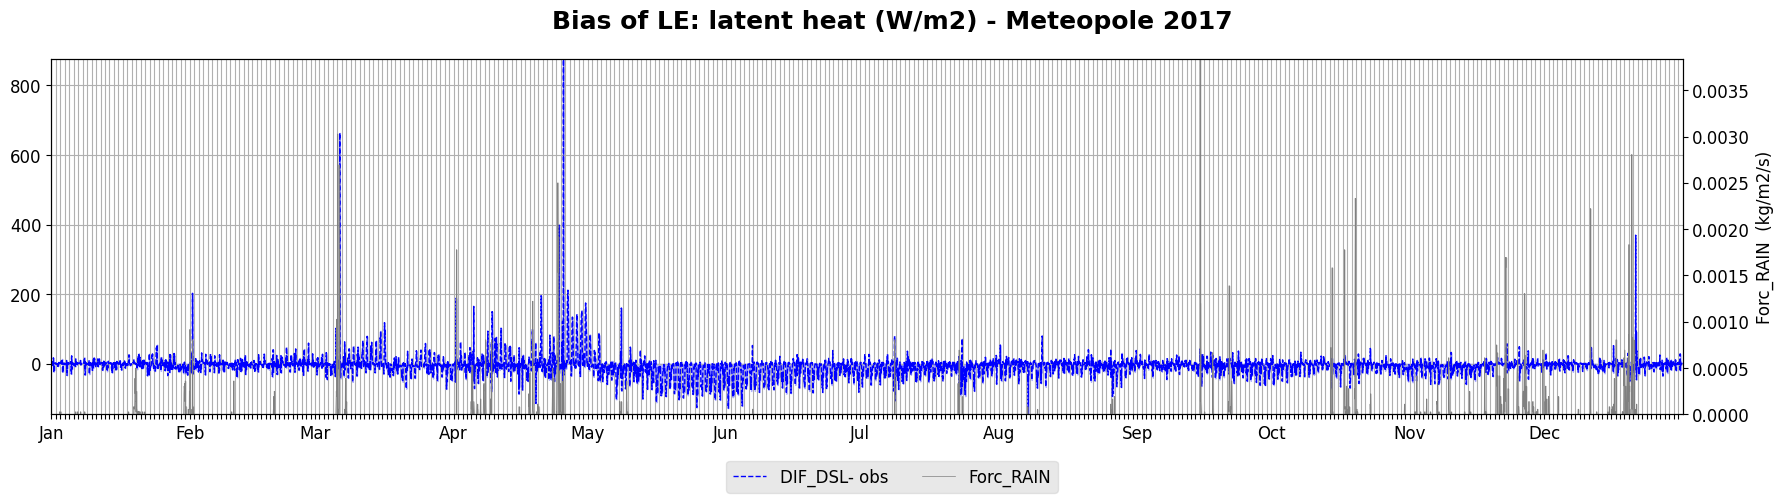

In [29]:
campo = 5 # posición en field_vars lo voy a hacer para que por ahora salga de uno en uno (H=4)
add_forc = True # añadir o no un forzamiento
forzamiento = 3 # se podría hacer para otro forzamiento más pero no lo recomiendo, porque sería tener 3 ejes y en una misma gráfica (Forc_RAIN=3)
experiments = [1] #, 2, 3] # Posiciones. Por si no quiero representarlos todos
# exps = ['DIF_REF', 'DIF_DSL', 'MEB_REF', 'MEB_DSL']

month_interv = [1, 12] # Intervalo de meses (Enero = 1). Ambos inclusive
# day_interv = [1, 15] # ESTÁ PENDIENTE, hacer para dentro de un solo mes supongo? por ahora

observation = True # Para ver o no las observaciones de H y LE

# graph_type = 'diario'
graph_type = 'horario'


########## Ahora ya la figura, esto no se debería necesitar editar:
meses = [calendar.month_abbr[i] for i in range(1, 13)] + ['Jan']
dias_por_mes = [calendar.monthrange(2017, i)[1] for i in range(1, 13)] 
dias_por_mes.insert(0, 0)

if graph_type == 'diario':
  posiciones_meses = np.cumsum(dias_por_mes)
  y = MAJA_daily
elif graph_type == 'horario':
  posiciones_meses = np.cumsum(dias_por_mes)*24
  y = MAJA_hours

fig, ax1 = plt.subplots(figsize=(18,5))

if add_forc == True:
  ax2 = ax1.twinx()
  ax2.set_ylabel(forcing_vars[forzamiento]+'  ('+forcing_units[forzamiento]+')')
  ax2.plot(y[forcing_vars[forzamiento]].values, color=colors[6], label=forcing_vars[forzamiento], linewidth=0.5)
  ax2.fill_between(np.arange(0,len(y)),y[forcing_vars[forzamiento]].values, color=colors[6], alpha=0.3)
  ax2.set_ylim([np.min(y[forcing_vars[forzamiento]].values), np.max(y[forcing_vars[forzamiento]].values)]) ### a ver si me convence
ax1.grid(True)

minimos, maximos = [], []
if observation == True and field_vars[campo] in my_dict:
  for exp in experiments:
    ax1.plot(y[field_vars[campo]+'_'+exps[exp]].values - y[my_dict[field_vars[campo]]].values,
             label=exps[exp]+'- obs', color=colors[exp], linestyle=styles[exp], linewidth=1)
    ax1.fill_between(np.arange(0,len(y)), y[field_vars[campo]+'_'+exps[exp]].values - y[my_dict[field_vars[campo]]].values, color=colors[exp], alpha=0.3)
    minimos.append(np.min(y[field_vars[campo]+'_'+exps[exp]].values - y[my_dict[field_vars[campo]]].values))
    maximos.append(np.max(y[field_vars[campo]+'_'+exps[exp]].values - y[my_dict[field_vars[campo]]].values))

max_absoluto = max(max(abs(x) for x in minimos), max(abs(x) for x in maximos))
ax1.set_ylim([-max_absoluto, max_absoluto])
# ax1.set_ylim([-250, 250]) ####
ax1.set_ylim([np.min(minimos), np.max(maximos)])
fig.legend(facecolor='lightgray',framealpha=0.5, ncol=6, loc='lower center')
fig.suptitle('Bias of '+field_vars[campo]+': '+field_names[campo]+' ('+field_units[campo]+') - Meteopole 2017', fontsize=18, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(bottom=0.17)

plt.xticks(posiciones_meses, meses)

if graph_type == 'horario':
  plt.xticks(np.arange(0,365)*24)

plt.xlim([posiciones_meses[month_interv[0] - 1], posiciones_meses[month_interv[1]]]) # Esto para sacar meses concretos


plt.show()
plt.close()

# PROYECTO "SESGOS 2.0":

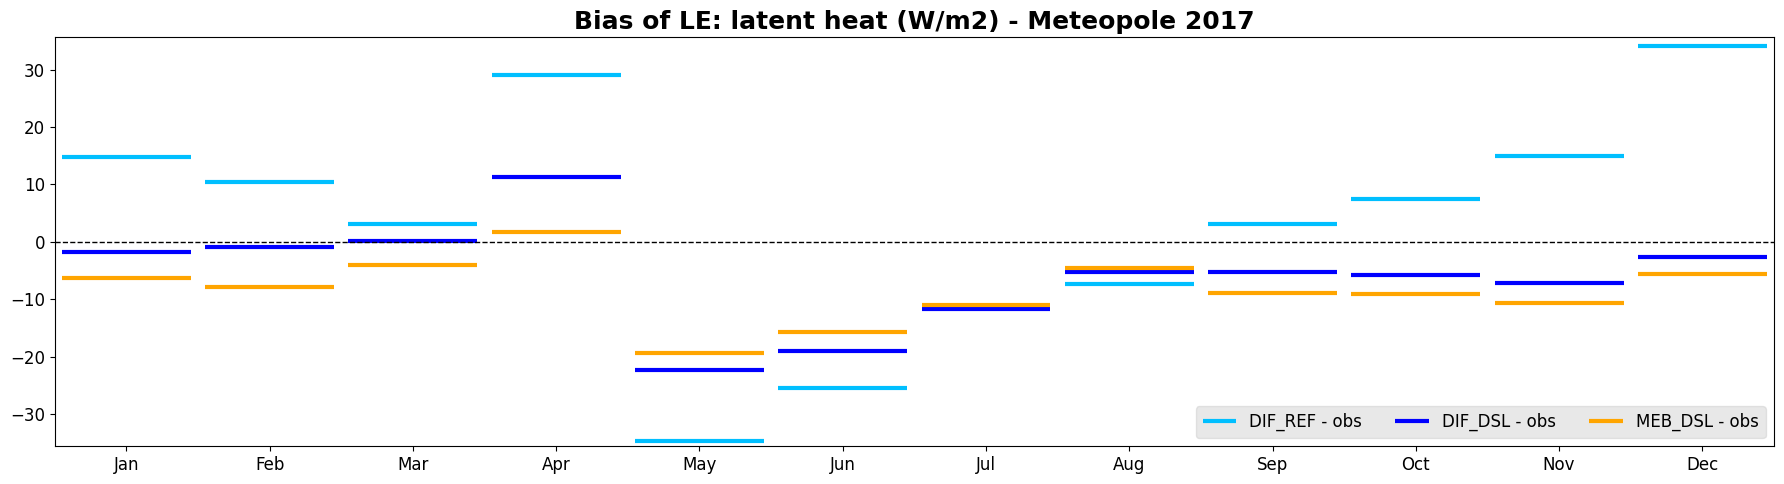

In [30]:
campo = 5

dif_ref = MAJA_hours[field_vars[campo]+'_'+exps[0]] - MAJA_hours[my_dict[field_vars[campo]]]
dif_dsl = MAJA_hours[field_vars[campo]+'_'+exps[1]] - MAJA_hours[my_dict[field_vars[campo]]]
meb_dsl = MAJA_hours[field_vars[campo]+'_'+exps[2]] - MAJA_hours[my_dict[field_vars[campo]]]

series1 = dif_ref.groupby(level=0).mean().values
series2 = dif_dsl.groupby(level=0).mean().values
series3 = meb_dsl.groupby(level=0).mean().values

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(18, 5))

x = np.arange(len(meses[:-1]))

dx = 0.45

# Añadir líneas horizontales para cada serie en cada mes
ax.hlines(series1, x - dx, x + dx, color=colors[0], label='DIF_REF - obs', lw=3)
ax.hlines(series2, x - dx, x + dx, color=colors[1], label='DIF_DSL - obs', lw=3)
ax.hlines(series3, x - dx, x + dx, color=colors[2], label='MEB_DSL - obs', lw=3)

ax.axhline(0, color='black', linestyle='--', linewidth=1)

ax.set_title('Comparación de 4 series con líneas horizontales')
ax.set_xticks(x)
ax.set_xticklabels(meses[:-1])

all_series = np.hstack((series1, series2, series3))

plt.xlim([-0.5,11.5])
plt.ylim([-np.max(abs(all_series))-1, np.max(abs(all_series))+1])

plt.legend(facecolor='lightgray',framealpha=0.5, ncol=6, loc='lower right')
ax.set_title('Bias of '+field_vars[campo]+': '+field_names[campo]+' ('+field_units[campo]+') - Meteopole 2017', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

In [31]:
print('media 1:', np.mean(abs(series1)))
print('suma 1:', np.sum(abs(series1)))
print('desv tipica 1:', np.std(series1))
print('')
print('media 2:', np.mean(abs(series2)))
print('suma 2:', np.sum(abs(series2)))
print('desv tipica 1:', np.std(series2))
print('')
print('media 3:', np.mean(abs(series3)))
print('suma 3:', np.sum(abs(series3)))
print('desv tipica 1:', np.std(series3))

media 1: 16.30185096745795
suma 1: 195.6222116094954
desv tipica 1: 19.448377423589367

media 2: 7.775971466537911
suma 2: 93.31165759845493
desv tipica 1: 8.49083122025337

media 3: 8.748892176200462
suma 3: 104.98670611440554
desv tipica 1: 5.283834350635136
